In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from tqdm import tqdm
pd.set_option('display.float_format', lambda x: '%.4f' % x) #suppress scientific notation
#To display all the rows: pd.set_option('display.max_rows', None)
#To fix it: pd.set_option('display.max_rows', 20)

External transactions:

- "blockNumber": the block number in which the transaction was confirmed
- "timeStamp": the Unix timestamp (in seconds) of when the transaction was confirmed
- "hash": the transaction hash of the external transaction
- "from": the Ethereum address that initiated the transaction
- "to": the Ethereum address that received the transaction
- "value": the amount of Ether transferred in the transaction
- "gas": the amount of gas used in the transaction
- "gasPrice": the gas price at which the transaction was executed
- "isError": whether the transaction was successful (0) or not (1)
- "txreceipt_status": the status of the transaction receipt, if available (e.g. "0" for fail, "1" for success)
- "input": the input data of the transaction (if any)

Internal transactions:

- "blockNumber": the block number in which the transaction was confirmed
- "timeStamp": the Unix timestamp (in seconds) of when the transaction was confirmed
- "hash": the transaction hash of the internal transaction
- "from": the Ethereum address that initiated the internal transaction
- "to": the Ethereum address that received the internal transaction (which may be a smart contract address)
- "value": the amount of Ether transferred in the internal transaction
- "contractAddress": the address of the smart contract (if any) involved in the internal transaction
- "input": the input data of the internal transaction (if any)
- "type": the type of the internal transaction (e.g. "CALL" or "CREATE")
- "gas": the amount of gas used in the internal transaction
- "gasUsed": the amount of gas used by the transaction (if available)
- "traceId": the unique ID of the transaction trace, if available

# Ponzi Contracts

In [2]:
ponzi_ext = pd.read_csv('all_external.csv')
ponzi_int = pd.read_csv('all_internal.csv')
addresses = pd.read_csv('address_to_name.csv')

In [3]:
len(set(addresses['address']))

429

In [4]:
#Fixing NaN in ponzi_int => this enables to know when the contract is being created.
#Internal transactions with to = Nan are simply transactions used to create the contract
to = []
for i in range(ponzi_int.shape[0]):
    if pd.isna(ponzi_int.loc[i, 'to']):
        to.append(ponzi_int.loc[i+1, 'from'])
    else:
        to.append(ponzi_int.loc[i, 'to'])
ponzi_int['to'] = to

#Dropping duplicate transactions
print('Number of transactions before cleaning:', ponzi_int.shape[0])
ponzi_int = ponzi_int.drop_duplicates(subset=['blockNumber', 'timeStamp', 'hash', 'from', 'to', 'value'])
print('Number of transactions after cleaning:', ponzi_int.shape[0])

#fixing internal transactions which are in pratice external ones
inflow_from_internal = ponzi_int[ponzi_int['to'].isin(addresses['address'])].reset_index(drop=True)
ponzi_int = ponzi_int[~ponzi_int['to'].isin(addresses['address'])].reset_index(drop=True)
print('Number of contracts:', len(set(ponzi_int['from'])))

Number of transactions before cleaning: 53572
Number of transactions after cleaning: 37795
Number of contracts: 298


internal transactions are of two kinds: the ones sent to the contract under
observation, and the ones sent from it. The first case happens when,
instead of sending her money directly to a Ponzi scheme, a user goes
through another contract (typically, a wallet contract): hence the amount
linked to the transaction is part of the inflow of the contract. The second
case happens when the contract sends a payout to some user: in this case,
the transaction amount is part of the outflow of the contract.

In [5]:
#Fixing NaN in ponzi_ext => this enables to know when the contract is being created.
#I am filling with bfill because transactions for each contract are ordered by date, therefore allowing to fill with the next value
ponzi_ext['to'] = ponzi_ext['to'].fillna(method='bfill')
ponzi_ext = pd.concat([ponzi_ext, inflow_from_internal], axis=0)
#Dropping duplicate transactions
print('Number of transactions before cleaning:', ponzi_ext.shape[0])
ponzi_ext = ponzi_ext.drop_duplicates(subset=['blockNumber', 'timeStamp', 'hash','nonce', 'blockHash','transactionIndex', 'from', 'to', 'value'])
print('Number of transactions after cleaning:', ponzi_ext.shape[0])
print('Number of contracts:', len(set(ponzi_ext['to'])))

Number of transactions before cleaning: 91791
Number of transactions after cleaning: 84015
Number of contracts: 368


In [6]:
def determining_node(row):
    if pd.isnull(row['from']) and pd.isnull(row['to']):
        print(row)
        raise Exception ('Both missing')
    elif pd.isnull(row['from']):
        return row['to']
    elif pd.isnull(row['to']):
        return row['from']
    else:
        return row['from']

def to_drop(row):
    if row['paid']==0 and row['received']==0:
        return 1 
    return 0

In [7]:
ponzi_ext['node']= ponzi_ext.apply(determining_node, axis=1) #fixing issues with Nodes missing
ponzi_int['node']= ponzi_int.apply(determining_node, axis=1)
all_cols_ponzi_ext = ponzi_ext.copy()#.rename({'to':'contract_address'}, axis=1)
all_cols_ponzi_ext['contract_address']=all_cols_ponzi_ext['to']
all_cols_ponzi_int = ponzi_int.copy()#.rename({'from':'contract_address'}, axis=1)
all_cols_ponzi_int['contract_address']=all_cols_ponzi_int['from']
ponzi_ext = ponzi_ext[['from', 'to', 'Date', 'Value_usd', 'isError']].rename({'to':'contract_address'}, axis=1)
ponzi_int = ponzi_int[['from', 'to', 'Date', 'Value_usd', 'isError']].rename({'from':'contract_address'}, axis=1)

in ponzi_ext ci sono 368 ponzi contracts. In addresses ce ne sono 429. La differenza è dovuta ai contratti che non hanno alcuna transazione (se non la transazione di costruzione del contratto, registrata come Nan in Ponzi_ext).

In ponzi_int ci sono 298 contratti. I contratti presenti in ext e non int non hanno redistribuito denaro ai propri investitori.

tutti i contratti ponzi_ext hanno una controparte ponzi_int ad eccezione di 2 contratti. Tali contratti, tuttavia, non presentano alcuna external transaction e le uniche internal transactions sono self-destruct

In [8]:
exts_payoffs = ponzi_ext.groupby(['contract_address', 'from'])[['Value_usd','isError']].sum().reset_index().rename({'Value_usd':'paid', 'isError':'error_ext'}, axis=1)
ints_payoffs = ponzi_int.groupby(['contract_address', 'to'])[['Value_usd','isError']].sum().reset_index().rename({'Value_usd':'received', 'isError':'error_int'}, axis=1)

In [9]:
#merging payoffs tables
merged_payoffs = pd.merge(exts_payoffs, ints_payoffs, left_on = ['contract_address', 'from'], right_on = ['contract_address', 'to'], how='outer')
merged_payoffs['node']= merged_payoffs.apply(determining_node, axis=1) #fixing issues with Nodes missing
#merged_payoffs = merged_payoffs[~merged_payoffs['node'].isin(addresses['address'])] 
#print('Checking absence of contracts in nodes:',merged_payoffs.shape==merged_payoffs[~merged_payoffs['node'].isin(addresses['address'])].shape)
merged_payoffs = merged_payoffs[['contract_address', 'node', 'paid', 'received', 'error_ext', 'error_int']]
merged_payoffs = merged_payoffs.fillna(0) #filling paid and received missing
merged_payoffs['net_payoff']=merged_payoffs['received']-merged_payoffs['paid']
merged_payoffs['to_drop'] = merged_payoffs.apply(to_drop, axis=1) #dropping observations with both paid and received = 0
merged_payoffs = merged_payoffs[merged_payoffs['to_drop']==0].reset_index(drop=True)
merged_payoffs.head(5)

,contract_address,node,paid,received,error_ext,error_int,net_payoff,to_drop
0,0x007d42b9192b8c087b0d3e6ef73aae48e74b41c1,0x7e6f7232ddddc7d5a075150db12e5235455d9432,331.1600,0.0000,0.0000,0.0000,-331.1600,0
1,0x007d42b9192b8c087b0d3e6ef73aae48e74b41c1,0xcda1c09b25908c03549c0ed95e81b3fe736e280a,0.0000,0.0000,0.0000,0.0000,-0.0000,0
2,0x00efd61b0d94ccd82f3922d26efdd3ed9859081a,0x049bed1598655b64f09e4835084fbc502ab1ad86,41.4243,6.0997,0.0000,0.0000,-35.3246,0
3,0x00efd61b0d94ccd82f3922d26efdd3ed9859081a,0x05f2c11996d73288abe8a31d8b593a693ff2e5d8,414.2430,111.9757,0.0000,0.0000,-302.2673,0
4,0x00efd61b0d94ccd82f3922d26efdd3ed9859081a,0x0668dea6b5ec94d7ce3c43fe477888eee2fc1b2c,0.0000,0.0000,1.0000,0.0000,-0.0000,0


Note: there are some nodes which are not making any transaction towards the ponzi_contract. Therefore they payed 0

Also: some contracts have only 1 node, I will drop them

Also2: some contracts are made from one ponzi contract to another ponzi contract. I will keep those as ponzi entering into a contract with another ponzi acts as a node

In [10]:
mask = merged_payoffs.groupby('contract_address')[['node']].nunique().reset_index()
mask = mask[mask['node']>=3]
print('Number of contracts before:', len(set(merged_payoffs['contract_address'])))
merged_payoffs = merged_payoffs[merged_payoffs['contract_address'].isin(mask['contract_address'])].reset_index(drop=True)
print('Number of contracts after:', len(set(merged_payoffs['contract_address'])))
#Adding the Ponzi name
merged_payoffs = pd.merge(merged_payoffs, addresses, left_on='contract_address', right_on='address')

Number of contracts before: 336
Number of contracts after: 239


In [11]:
### Cleaning ponzi_ext and ponzi_int so as to keep only the contracts with at least 3 transactions
print('Number of external transactions prior to cleaning the contracts:' ,ponzi_ext.shape[0], 'Number of contracts:', len(set(ponzi_ext['contract_address'])))
ponzi_ext = ponzi_ext[ponzi_ext['contract_address'].isin(merged_payoffs['address'])]
print('Number of external transactions after cleaning the contracts:' ,ponzi_ext.shape[0], 'Number of contracts:', len(set(ponzi_ext['contract_address'])))


print('\nNumber of internal transactions prior to cleaning the contracts:' ,ponzi_int.shape[0], 'Number of contracts:', len(set(ponzi_int['contract_address'])))
ponzi_int = ponzi_int[ponzi_int['contract_address'].isin(merged_payoffs['address'])]
print('Number of internal transactions after cleaning the contracts:' ,ponzi_int.shape[0], 'Number of contracts:', len(set(ponzi_int['contract_address'])))

Number of external transactions prior to cleaning the contracts: 84015 Number of contracts: 368
Number of external transactions after cleaning the contracts: 79565 Number of contracts: 239

Number of internal transactions prior to cleaning the contracts: 30148 Number of contracts: 298
Number of internal transactions after cleaning the contracts: 29954 Number of contracts: 233


### Descriptive analysis 

--- Transaction costs by contract ---
Total Transaction costs by contract: $ 44147.92
Avg Transaction costs by contract: $ 119.97
Standard deviation Transaction costs by contract: $ 568.52
Median Transaction costs by contract: $ 3.96
1st Quartile Transaction costs by contract: $ 0.49
3rd Quartile Transaction costs by contract: $ 26.34
Max Transaction costs by contract: $ 5236.18
Min Transaction costs by contract: $ 0.0

--- Transaction costs by user ---
Total Transaction costs by user: $ 44147.92
Avg Transaction costs by user: $ 2.3
Standard deviation Transaction costs by user: $ 19.67
Median Transaction costs by user: $ 0.64
1st Quartile Transaction costs by user: $ 0.1
3rd Quartile Transaction costs by user: $ 1.38
Max Transaction costs by user: $ 2279.62
Min Transaction costs by user: $ 0.0


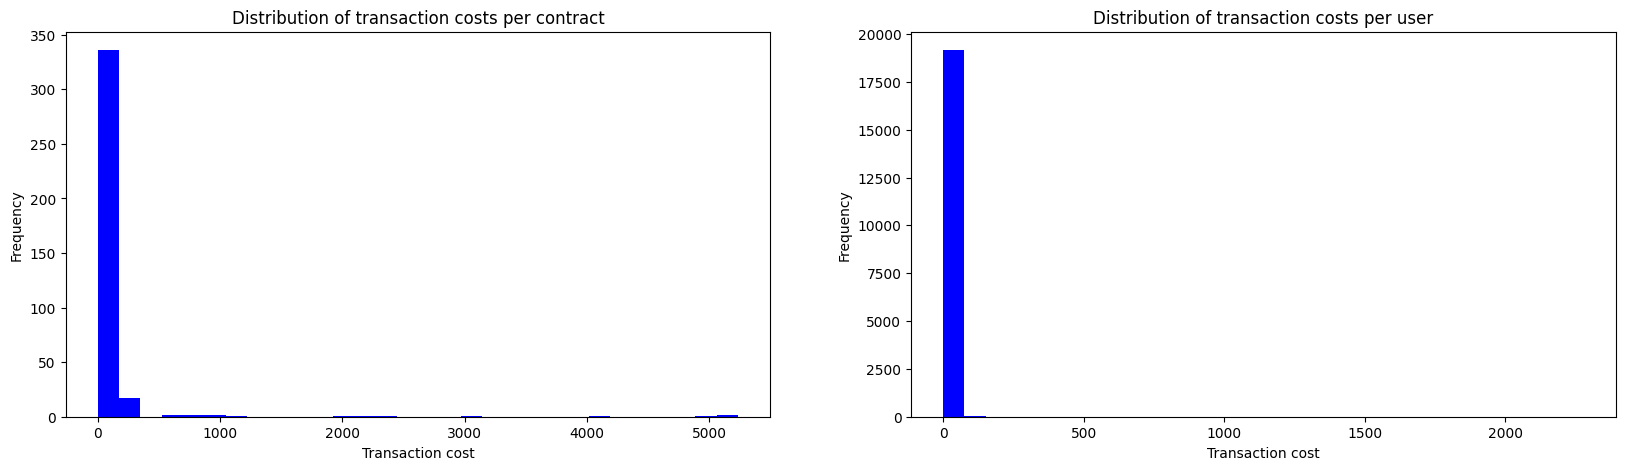

In [12]:
print('--- Transaction costs by contract ---')
temp_df = all_cols_ponzi_ext.groupby('contract_address')[['Transaction_cost_usd']].sum()
print('Total Transaction costs by contract: $', np.round(np.sum(temp_df['Transaction_cost_usd']),2))
print('Avg Transaction costs by contract: $', np.round(np.mean(temp_df['Transaction_cost_usd']),2))
print('Standard deviation Transaction costs by contract: $', np.round(np.std(temp_df['Transaction_cost_usd']),2))
print('Median Transaction costs by contract: $', np.round(np.median(temp_df['Transaction_cost_usd']),2))
print('1st Quartile Transaction costs by contract: $', np.round(np.quantile(temp_df['Transaction_cost_usd'], 0.25),2))
print('3rd Quartile Transaction costs by contract: $', np.round(np.quantile(temp_df['Transaction_cost_usd'], 0.75),2))
print('Max Transaction costs by contract: $', np.round(np.max(temp_df['Transaction_cost_usd']), 2))
print('Min Transaction costs by contract: $', np.round(np.min(temp_df['Transaction_cost_usd']), 2))

fig, axs = plt.subplots(ncols=2,figsize=(20,5))
ax=axs[0]
ax.hist(temp_df['Transaction_cost_usd'], bins=30, color='blue')
ax.set_title('Distribution of transaction costs per contract')
ax.set_xlabel('Transaction cost')
ax.set_ylabel('Frequency')

print('\n--- Transaction costs by user ---')
temp_df = all_cols_ponzi_ext.groupby('from')[['Transaction_cost_usd']].sum()
print('Total Transaction costs by user: $', np.round(np.sum(temp_df['Transaction_cost_usd']),2))
print('Avg Transaction costs by user: $', np.round(np.mean(temp_df['Transaction_cost_usd']),2))
print('Standard deviation Transaction costs by user: $', np.round(np.std(temp_df['Transaction_cost_usd']),2))
print('Median Transaction costs by user: $', np.round(np.median(temp_df['Transaction_cost_usd']),2))
print('1st Quartile Transaction costs by user: $', np.round(np.quantile(temp_df['Transaction_cost_usd'], 0.25),2))
print('3rd Quartile Transaction costs by user: $', np.round(np.quantile(temp_df['Transaction_cost_usd'], 0.75),2))
print('Max Transaction costs by user: $', np.round(np.max(temp_df['Transaction_cost_usd']), 2))
print('Min Transaction costs by user: $', np.round(np.min(temp_df['Transaction_cost_usd']), 2))
ax=axs[1]
ax.hist(temp_df['Transaction_cost_usd'], bins=30, color='blue')
ax.set_title('Distribution of transaction costs per user')
ax.set_xlabel('Transaction cost')
ax.set_ylabel('Frequency')

plt.show()

In [13]:
print('----- Inflow transactions ----- \n')
print('Total amount of money collected: $', f'{np.round(merged_payoffs.paid.sum(),2):,}')

temp_df = merged_payoffs.groupby('contract_address')[['paid']].sum().reset_index()
temp_df = temp_df[temp_df['paid']==temp_df['paid'].max()].reset_index(drop=True)
print('Max money attracted by a contract: $', f'{np.round(temp_df.iloc[0,1],2):,}',' --- Contract associated:', addresses[addresses['address']==temp_df.iloc[0,0]]['name'].iloc[0])

temp_df = merged_payoffs.groupby('contract_address')[['paid']].sum().reset_index()
temp_df = temp_df[temp_df['paid']==temp_df['paid'].min()].reset_index(drop=True)
print('Min money attracted by a contract: $', f'{np.round(temp_df.iloc[0,1],2):,}',' --- Contract associated:', addresses[addresses['address']==temp_df.iloc[0,0]]['name'].iloc[0])

temp_df = merged_payoffs.groupby('contract_address')[['paid']].sum().reset_index()
print('Avg money attracted by a contract: $', f'{np.round(np.mean(temp_df.paid),2):,}')
print('Standard deviation money attracted by a contract: $', f'{np.round(np.std(temp_df.paid),2):,}')
print('Median money attracted by a contract: $', f'{np.round(np.median(temp_df.paid),2):,}')
print('1st Quartile money attracted by a contract: $', f'{np.round(np.quantile(temp_df.paid, 0.25),2):,}')
print('3rd Quartile money attracted by a contract: $', f'{np.round(np.quantile(temp_df.paid, 0.75),2):,}')

print('\n----- Outflow transactions ----- \n')
print('Total amount of money paid out: $', f'{np.round(merged_payoffs.received.sum(),2):,}')

temp_df = merged_payoffs.groupby('contract_address')[['received']].sum().reset_index()
temp_df = temp_df[temp_df['received']==temp_df['received'].max()].reset_index(drop=True)
print('Max money paid by a contract: $', f'{np.round(temp_df.iloc[0,1],2):,}',' --- Contract associated:', addresses[addresses['address']==temp_df.iloc[0,0]]['name'].iloc[0])

temp_df = merged_payoffs.groupby('contract_address')[['received']].sum().reset_index()
temp_df = temp_df[temp_df['received']==temp_df['received'].min()].reset_index(drop=True)
print('Min money paid by a contract: $', f'{np.round(temp_df.iloc[0,1],2):,}',' --- Contract associated:', addresses[addresses['address']==temp_df.iloc[0,0]]['name'].iloc[0])

temp_df = merged_payoffs.groupby('contract_address')[['received']].sum().reset_index()
print('Avg money paid by a contract: $', f'{np.round(np.mean(temp_df.received),2):,}')
print('Standard deviation money paid by a contract: $', f'{np.round(np.std(temp_df.received),2):,}')
print('Median money paid by a contract: $', f'{np.round(np.median(temp_df.received),2):,}')
print('1st Quartile money paid by a contract: $', f'{np.round(np.quantile(temp_df.received, 0.25),2):,}')
print('3rd Quartile money paid by a contract: $', f'{np.round(np.quantile(temp_df.received, 0.75),2):,}')

----- Inflow transactions ----- 

Total amount of money collected: $ 21,706,902.13
Max money attracted by a contract: $ 7,290,782.93  --- Contract associated: Sociall: Token Sale
Min money attracted by a contract: $ 0.35  --- Contract associated: FiveForty
Avg money attracted by a contract: $ 90,823.86
Standard deviation money attracted by a contract: $ 592,928.91
Median money attracted by a contract: $ 1,110.09
1st Quartile money attracted by a contract: $ 188.29
3rd Quartile money attracted by a contract: $ 7,219.34

----- Outflow transactions ----- 

Total amount of money paid out: $ 20,282,393.93
Max money paid by a contract: $ 5,929,645.73  --- Contract associated: Sociall: Token Sale
Min money paid by a contract: $ 0.0  --- Contract associated: Tomeka
Avg money paid by a contract: $ 84,863.57
Standard deviation money paid by a contract: $ 538,267.1
Median money paid by a contract: $ 1,068.21
1st Quartile money paid by a contract: $ 146.85
3rd Quartile money paid by a contract: $ 

In [14]:
def gini_coefficient(x):
    """Compute Gini coefficient of array of values"""
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    if np.mean(x)==0:
        return diffsum / (len(x)**2 * (np.mean(x)+1e-6))
    return diffsum / (len(x)**2 * (np.mean(x)))

def lorenz_curve(payments):
    payments = np.concatenate(payments)
    total_payments = np.sum(payments) +1e-6
    shares = np.cumsum(np.sort(payments)) / total_payments 
    x_points = np.append([0], shares)
    y_points = np.append([0], np.linspace(0, 1, len(shares)))
    return x_points, y_points

---- Contracts payouts ----
Avg Gini contract payouts: 0.68
Standard deviation Gini contract payouts: 0.22
Median Gini contract payouts: 0.72
1st Quartile Gini contract payouts: 0.59
3rd Quartile Gini contract payouts: 0.83
Max Gini: 1.0
Min Gini: 0.0

---- Contracts payins ----
Avg Gini contract payins: 0.61
Standard deviation Gini contract payins: 0.19
Median Gini contract payins: 0.63
1st Quartile Gini contract payins: 0.48
3rd Quartile Gini contract payins: 0.76
Max Gini: 0.98
Min Gini: 0.0


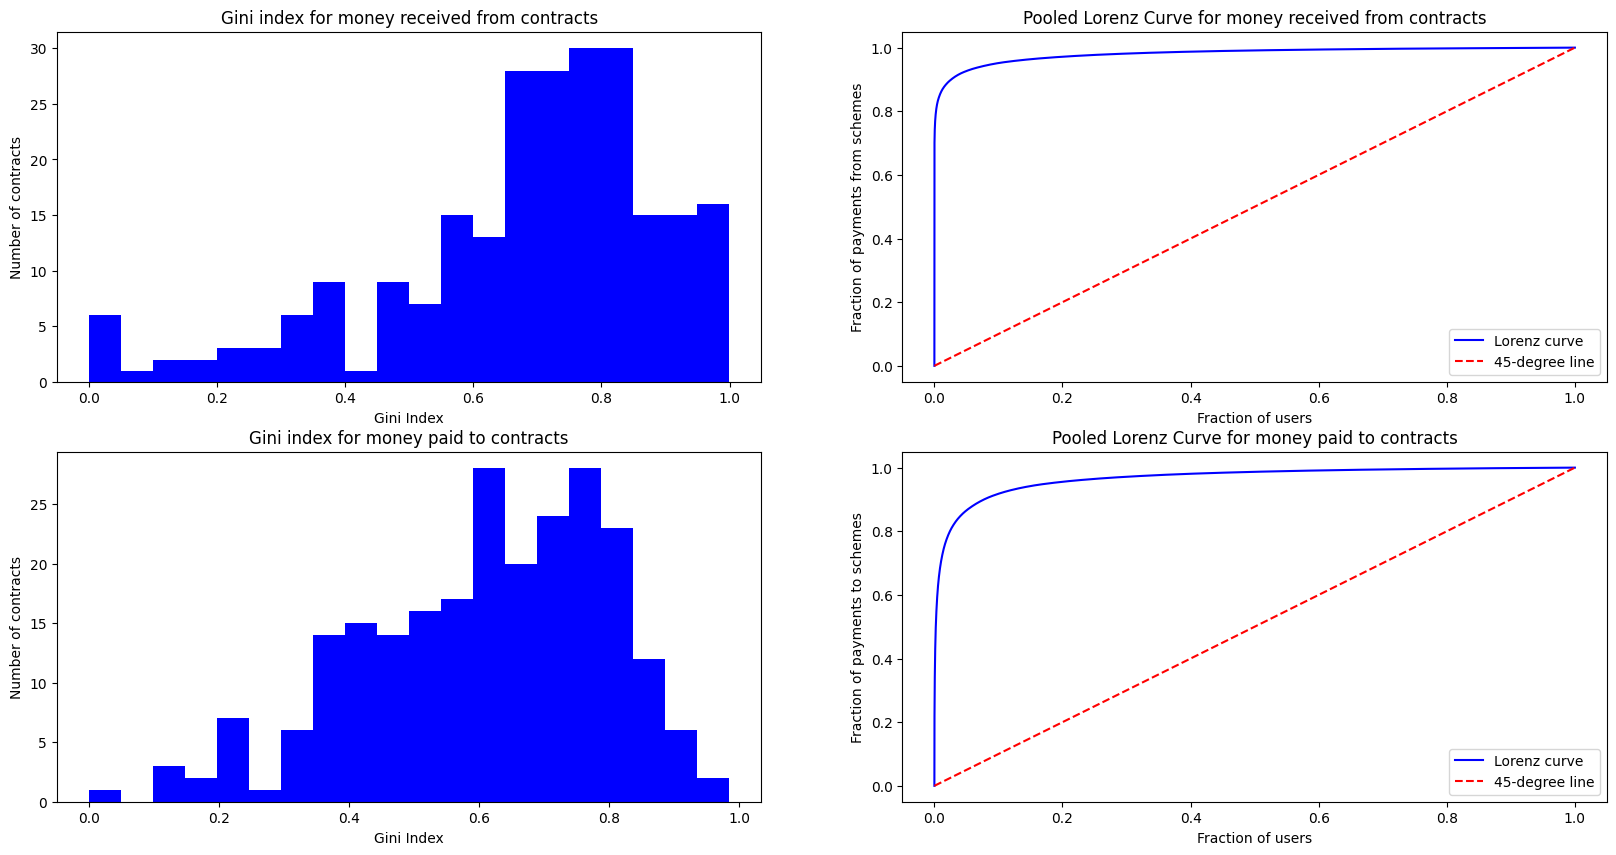

In [15]:
fig, axs = plt.subplots(nrows =2, ncols=2, figsize=(20,10))

ax=axs[0,0]
ginis = []
for i in set(merged_payoffs['contract_address']):
    ginis.append(gini_coefficient(merged_payoffs[merged_payoffs['contract_address']==i].reset_index()['received']))
ax.hist(ginis, color='blue', bins=20)
ax.set_xlabel('Gini Index')
ax.set_ylabel('Number of contracts')
ax.set_title('Gini index for money received from contracts')

lorenz = []
for i in set(merged_payoffs['contract_address']):
    temp_df = merged_payoffs[merged_payoffs['contract_address']==i].reset_index()
    vals = temp_df['received']/(temp_df['received'].sum()+1e-6)
    lorenz.append(vals.tolist())
lorenz_x_points, lorenz_y_points = lorenz_curve(lorenz)
ax=axs[0,1]
ax.plot(lorenz_x_points, lorenz_y_points, label='Lorenz curve', color='blue')
ax.plot([0, 1], [0, 1], label='45-degree line', linestyle='--', color='red')
ax.set_xlabel('Fraction of users')
ax.set_ylabel('Fraction of payments from schemes')
ax.legend()
ax.set_title('Pooled Lorenz Curve for money received from contracts')
print('---- Contracts payouts ----')
print('Avg Gini contract payouts:', np.round(np.mean(ginis),2))
print('Standard deviation Gini contract payouts:', np.round(np.std(ginis),2))
print('Median Gini contract payouts:', np.round(np.median(ginis),2))
print('1st Quartile Gini contract payouts:', np.round(np.quantile(ginis, 0.25),2))
print('3rd Quartile Gini contract payouts:', np.round(np.quantile(ginis, 0.75),2))
print('Max Gini:', np.round(np.max(ginis), 2))
print('Min Gini:', np.round(np.min(ginis), 2))

ax=axs[1,0]
ginis = []
for i in set(merged_payoffs['contract_address']):
    ginis.append(gini_coefficient(merged_payoffs[merged_payoffs['contract_address']==i].reset_index()['paid']))
ax.hist(ginis, color='blue', bins=20)
ax.set_xlabel('Gini Index')
ax.set_ylabel('Number of contracts')
ax.set_title('Gini index for money paid to contracts')

lorenz = []
for i in set(merged_payoffs['contract_address']):
    temp_df = merged_payoffs[merged_payoffs['contract_address']==i].reset_index()
    vals = temp_df['paid']/(temp_df['paid'].sum()+1e-6)
    lorenz.append(vals.tolist())
lorenz_x_points, lorenz_y_points = lorenz_curve(lorenz)
ax=axs[1,1]
ax.plot(lorenz_x_points, lorenz_y_points, label='Lorenz curve', color='blue')
ax.plot([0, 1], [0, 1], label='45-degree line', linestyle='--', color='red')
ax.set_xlabel('Fraction of users')
ax.set_ylabel('Fraction of payments to schemes')
ax.legend()
ax.set_title('Pooled Lorenz Curve for money paid to contracts')

print('\n---- Contracts payins ----')
print('Avg Gini contract payins:', np.round(np.mean(ginis),2))
print('Standard deviation Gini contract payins:', np.round(np.std(ginis),2))
print('Median Gini contract payins:', np.round(np.median(ginis),2))
print('1st Quartile Gini contract payins:', np.round(np.quantile(ginis, 0.25),2))
print('3rd Quartile Gini contract payins:', np.round(np.quantile(ginis, 0.75),2))
print('Max Gini:', np.round(np.max(ginis), 2))
print('Min Gini:', np.round(np.min(ginis), 2))
plt.show()

In [16]:
temp_df = merged_payoffs.groupby('node')[['net_payoff']].sum().reset_index()
print('Fraction of users registering a loss:', np.round(100*temp_df[temp_df['net_payoff']<0].shape[0]/temp_df.shape[0], 2))
print('Fraction of users breaking even/making a profit:', np.round(100*temp_df[temp_df['net_payoff']>=0].shape[0]/temp_df.shape[0],2))

Fraction of users registering a loss: 86.29
Fraction of users breaking even/making a profit: 13.71


In [17]:
print('----- Errors internal transactions -----')
temp_df = merged_payoffs.groupby('contract_address')[['error_ext', 'error_int']].sum()
print('Total Errors:', np.round(np.sum(temp_df['error_int']),2))
print('Avg Errors:', np.round(np.mean(temp_df['error_int']),2))
print('Standard deviation Errors:', np.round(np.std(temp_df['error_int']),2))
print('Median Errors:', np.round(np.median(temp_df['error_int']),2))
print('1st Quartile Errors:', np.round(np.quantile(temp_df['error_int'], 0.25),2))
print('3rd Quartile Errors:', np.round(np.quantile(temp_df['error_int'], 0.75),2))
print('Max Errors:', np.round(np.max(temp_df['error_int']), 2))
print('Min Errors:', np.round(np.min(temp_df['error_int']), 2))
print('\n----- Errors external transactions -----')
print('Total Errors:', np.round(np.sum(temp_df['error_ext']),2))
print('Avg Errors:', np.round(np.mean(temp_df['error_ext']),2))
print('Standard deviation Errors:', np.round(np.std(temp_df['error_ext']),2))
print('Median Errors:', np.round(np.median(temp_df['error_ext']),2))
print('1st Quartile Errors:', np.round(np.quantile(temp_df['error_ext'], 0.25),2))
print('3rd Quartile Errors:', np.round(np.quantile(temp_df['error_ext'], 0.75),2))
print('Max Errors:', np.round(np.max(temp_df['error_ext']), 2))
print('Min Errors:', np.round(np.min(temp_df['error_ext']), 2))

----- Errors internal transactions -----
Total Errors: 3315.0
Avg Errors: 13.87
Standard deviation Errors: 170.38
Median Errors: 0.0
1st Quartile Errors: 0.0
3rd Quartile Errors: 0.0
Max Errors: 2627.0
Min Errors: 0.0

----- Errors external transactions -----
Total Errors: 4925.0
Avg Errors: 20.61
Standard deviation Errors: 90.34
Median Errors: 1.0
1st Quartile Errors: 0.0
3rd Quartile Errors: 6.0
Max Errors: 959.0
Min Errors: 0.0


In [18]:
paying_users = []
paid_users = []
profit_users = []
loss_users = []
for i in set(merged_payoffs['contract_address']):
    temp_df = merged_payoffs[merged_payoffs['contract_address']==i].reset_index(drop=True)
    paying_users.append(temp_df[temp_df['paid']>0]['node'].nunique())
    paid_users.append(temp_df[temp_df['received']>0]['node'].nunique())
    profit_users.append(temp_df[temp_df['net_payoff']>0]['node'].nunique())
    loss_users.append(temp_df[temp_df['net_payoff']<0]['node'].nunique())

print('--- Contracts in-degrees ---')
print('Total number of individual users:', np.round(np.sum(paying_users),2))
print('Average number of individual users:', np.round(np.mean(paying_users),2))
print('Standard deviation:', np.round(np.std(paying_users),2))
print('Median number of individual users:', np.round(np.median(paying_users),2))
print('1st Quartile:', np.round(np.quantile(paying_users, 0.25),2))
print('3rd Quartile:', np.round(np.quantile(paying_users, 0.75),2))
print('Max individuals:', np.round(np.max(paying_users), 2))
print('Min individuals:', np.round(np.min(paying_users), 2))

print('\n--- Contracts out-degrees ---')
print('Total number of individual users:', np.round(np.sum(paid_users),2))
print('Average number of individual users:', np.round(np.mean(paid_users),2))
print('Standard deviation:', np.round(np.std(paid_users),2))
print('Median number of individual users:', np.round(np.median(paid_users),2))
print('1st Quartile:', np.round(np.quantile(paid_users, 0.25),2))
print('3rd Quartile:', np.round(np.quantile(paid_users, 0.75),2))
print('Max individuals:', np.round(np.max(paid_users), 2))
print('Min individuals:', np.round(np.min(paid_users), 2))

--- Contracts in-degrees ---
Total number of individual users: 19447
Average number of individual users: 81.37
Standard deviation: 351.2
Median number of individual users: 10.0
1st Quartile: 4.0
3rd Quartile: 40.5
Max individuals: 3731
Min individuals: 2

--- Contracts out-degrees ---
Total number of individual users: 7951
Average number of individual users: 33.27
Standard deviation: 142.64
Median number of individual users: 6.0
1st Quartile: 3.0
3rd Quartile: 26.0
Max individuals: 1723
Min individuals: 0


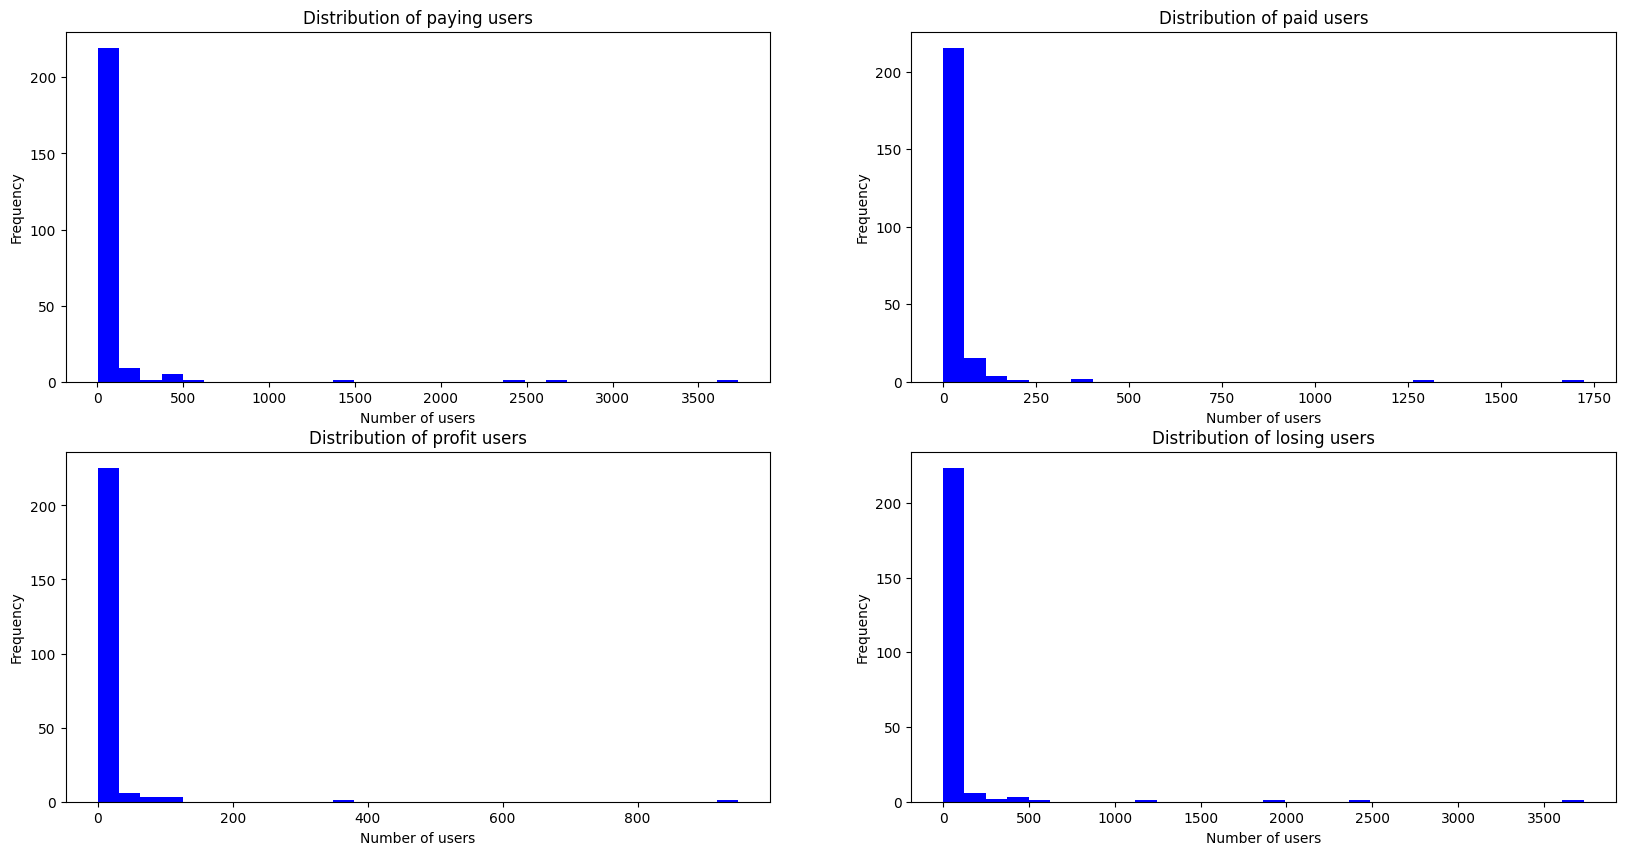

In [19]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
ax=axs[0,0]
ax.hist(paying_users, color='blue', bins=30)
ax.set_xlabel('Number of users')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of paying users')

ax=axs[0,1]
ax.hist(paid_users, color='blue', bins=30)
ax.set_xlabel('Number of users')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of paid users')

ax=axs[1,0]
ax.hist(profit_users, color='blue', bins=30)
ax.set_xlabel('Number of users')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of profit users')

ax=axs[1,1]
ax.hist(loss_users, color='blue', bins=30)
ax.set_xlabel('Number of users')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of losing users')

plt.show()

In [20]:
paying_amount = []
paid_amount = []
payoff_amount = []
for i in set(merged_payoffs['contract_address']):
    temp_df = merged_payoffs[merged_payoffs['contract_address']==i].reset_index(drop=True)
    paying_amount.append(temp_df[temp_df['paid']>0]['paid'].mean())
    paid_amount.append(temp_df[temp_df['received']>0]['received'].mean())
    payoff_amount.append(temp_df['net_payoff'].mean())

users_paying = merged_payoffs.groupby('node')[['paid']].sum().reset_index()
print('--- Amounts paid by users ---')
print('Total: $', f'{np.round(np.sum(users_paying.paid), 2):,}')
print('Average: $', f'{np.round(np.mean(users_paying.paid), 2):,}')
print('Standard deviation: $',f'{np.round(np.std(users_paying.paid), 2):,}')
print('Median: $', f'{np.round(np.median(users_paying.paid), 2):,}')
print('1st Quartile: $', f'{np.round(np.quantile(users_paying.paid, 0.25), 2):,}')
print('3rd Quartile: $', f'{np.round(np.quantile(users_paying.paid, 0.75), 2):,}')
print('Max: $', f'{np.round(np.max(users_paying.paid), 2):,}')
print('Min: $', f'{np.round(np.min(users_paying.paid), 2):,}')

users_receivig = merged_payoffs.groupby('node')[['received']].sum().reset_index()
print('\n--- Amounts received by users ---')
print('Total: $', f'{np.round(np.sum(users_receivig.received), 2):,}')
print('Average: $', f'{np.round(np.mean(users_receivig.received), 2):,}')
print('Standard deviation: $',f'{np.round(np.std(users_receivig.received), 2):,}')
print('Median: $', f'{np.round(np.median(users_receivig.received), 2):,}')
print('1st Quartile: $', f'{np.round(np.quantile(users_receivig.received, 0.25), 2):,}')
print('3rd Quartile: $', f'{np.round(np.quantile(users_receivig.received, 0.75), 2):,}')
print('Max: $', f'{np.round(np.max(users_receivig.received), 2):,}')
print('Min: $', f'{np.round(np.min(users_receivig.received), 2):,}')

users_profit = merged_payoffs.groupby('node')[['net_payoff']].sum().reset_index()
print('\n--- Profit by users ---')
print('Average: $', f'{np.round(np.mean(users_profit.net_payoff), 2):,}')
print('Standard deviation: $',f'{np.round(np.std(users_profit.net_payoff), 2):,}')
print('Median: $', f'{np.round(np.median(users_profit.net_payoff), 2):,}')
print('1st Quartile: $', f'{np.round(np.quantile(users_profit.net_payoff, 0.25), 2):,}')
print('3rd Quartile: $', f'{np.round(np.quantile(users_profit.net_payoff, 0.75), 2):,}')
print('Max: $', f'{np.round(np.max(users_profit.net_payoff), 2):,}')
print('Min: $', f'{np.round(np.min(users_profit.net_payoff), 2):,}')

--- Amounts paid by users ---
Total: $ 21,706,902.13
Average: $ 1,467.97
Standard deviation: $ 14,880.9
Median: $ 184.79
1st Quartile: $ 35.47
3rd Quartile: $ 634.8
Max: $ 1,047,459.18
Min: $ 0.0

--- Amounts received by users ---
Total: $ 20,282,393.93
Average: $ 1,371.64
Standard deviation: $ 52,408.74
Median: $ 0.0
1st Quartile: $ 0.0
3rd Quartile: $ 11.67
Max: $ 5,633,125.29
Min: $ 0.0

--- Profit by users ---
Average: $ -96.34
Standard deviation: $ 54,043.85
Median: $ -104.47
1st Quartile: $ -428.92
3rd Quartile: $ -11.72
Max: $ 5,633,125.29
Min: $ -1,047,459.18


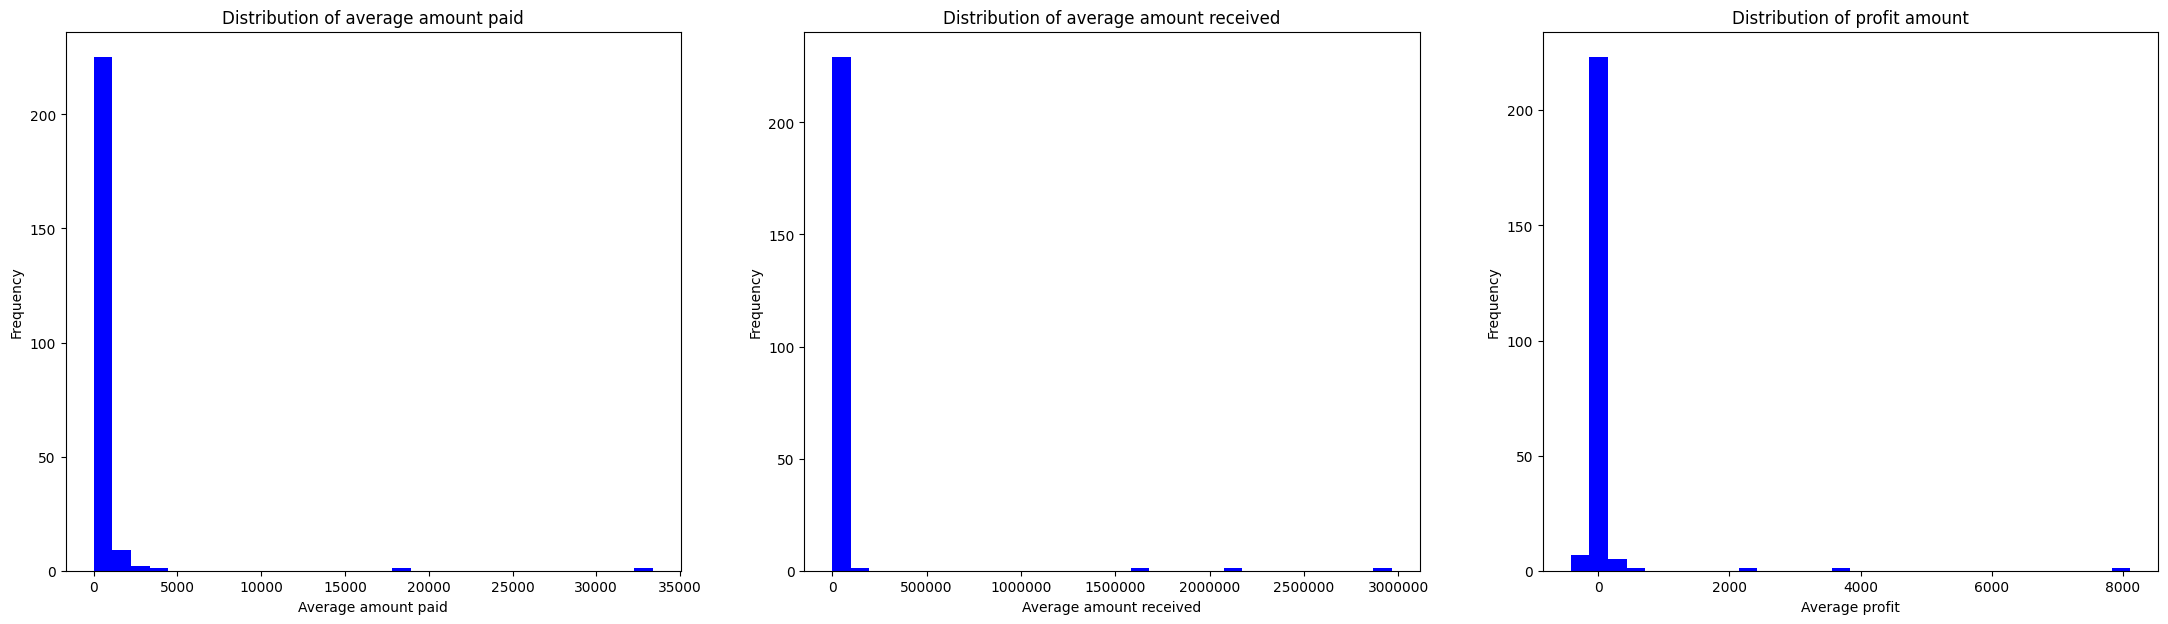

In [21]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(27,7))
ax=axs[0]
ax.hist(paying_amount, color='blue', bins=30)
ax.set_xlabel('Average amount paid')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of average amount paid')

ax=axs[1]
ax.hist(paid_amount, color='blue', bins=30)
ax.set_xlabel('Average amount received')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of average amount received')
ax.ticklabel_format(useOffset=False, style='plain')

ax=axs[2]
ax.hist(payoff_amount, color='blue', bins=30)
ax.set_xlabel('Average profit')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of profit amount')

plt.show()

Max lifetime: 2671 days --- Contract name: EthereumPyramid
Min lifetime: 0 days --- Contract name: TwoAndAHalfPonzi
Avg lifetime: 498.36 days
Standard deviation lifetime: 676.71 days
Median lifetime: 186.0 days
1st quartile lifetime: 3.0 days
3rd quartile lifetime: 729.0 days


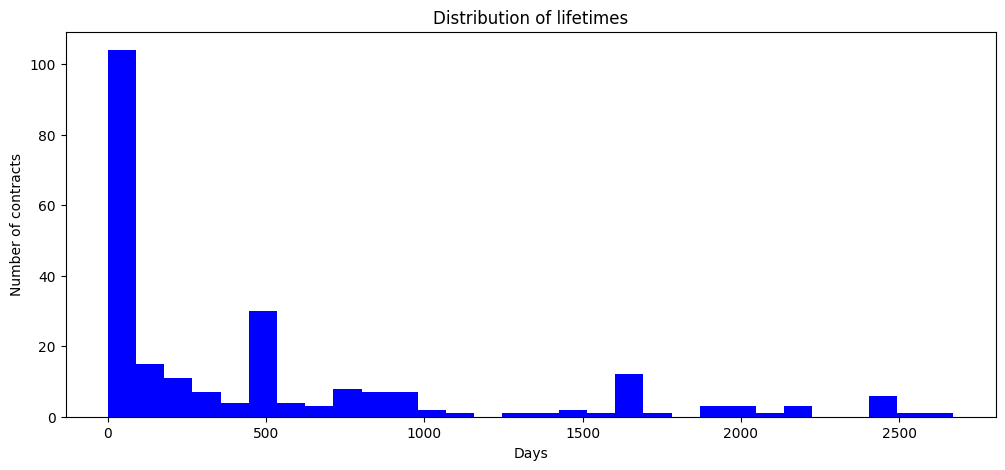

In [22]:
### Contracts lifetime
df_ext = ponzi_ext[['contract_address', 'Date','Value_usd']].rename({'Value_usd':'Paid to Ponzi'}, axis=1)
df_int = ponzi_int[['contract_address', 'Date', 'Value_usd']].rename({'Value_usd':'Paid from Ponzi'}, axis=1)
df_all = pd.concat([df_ext, df_int]).reset_index(drop=True)
df_all['Date_notgranular']=df_all['Date'].apply(lambda x: datetime.strptime(x[:7], '%Y-%m'))
df_all['Date']=df_all['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df_all = pd.merge(df_all, addresses, left_on='contract_address', right_on='address')
lifetimes = {}
for i in set(df_ext['contract_address']): #iterating only in contracts featuring external transactions
    temp_df = df_all[df_all['contract_address']==i]
    time_diff = temp_df['Date'].max() - temp_df['Date'].min()
    lifetimes[i]=time_diff.days

print('Max lifetime:', max(lifetimes.values()), 'days --- Contract name:', df_all[df_all['contract_address']==max(lifetimes, key=lifetimes.get)].iloc[0,-1])
print('Min lifetime:', min(lifetimes.values()), 'days --- Contract name:', df_all[df_all['contract_address']==min(lifetimes, key=lifetimes.get)].iloc[0,-1])
lifetimes = [i for i in lifetimes.values()]
print('Avg lifetime:', np.round(np.mean(lifetimes),2), 'days')
print('Standard deviation lifetime:',np.round(np.std(lifetimes),2), 'days')
print('Median lifetime:', np.median(lifetimes), 'days')
print('1st quartile lifetime:', np.quantile(lifetimes, q=0.25), 'days')
print('3rd quartile lifetime:', np.quantile(lifetimes, q=0.75), 'days')

fig, ax = plt.subplots(figsize=(12,5))
ax.hist(lifetimes, color='blue', bins=30)
ax.set_title('Distribution of lifetimes')
ax.set_xlabel('Days')
ax.set_ylabel('Number of contracts')
plt.show()

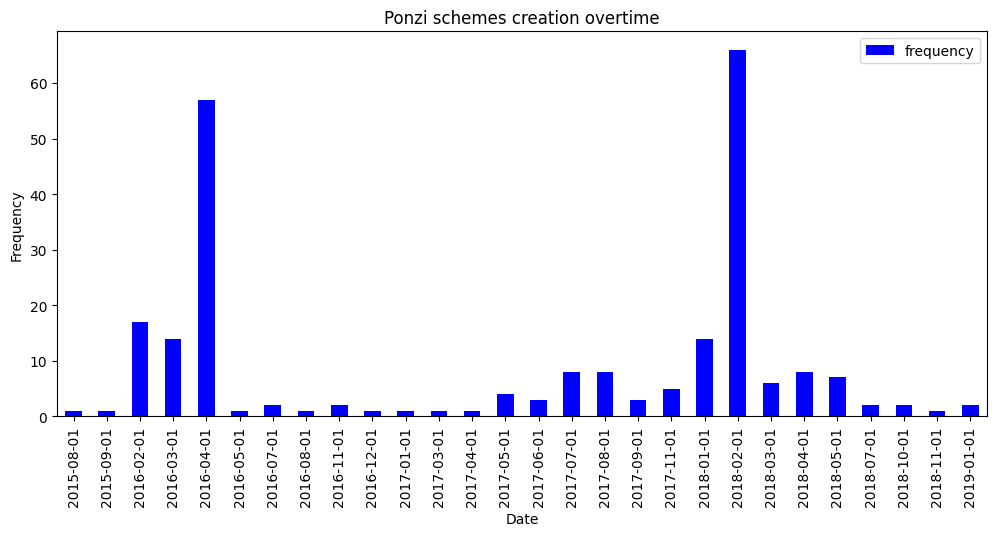

In [23]:
df_all_dateborn = df_all.groupby('contract_address')[['Date_notgranular']].min().reset_index()
fig, ax = plt.subplots(figsize=(12,5))
df_all_dateborn=df_all_dateborn.groupby('Date_notgranular').count().reset_index().rename({'contract_address':'frequency'},axis=1)
df_all_dateborn['Date_notgranular']=df_all_dateborn['Date_notgranular'].astype(str)
df_all_dateborn.plot.bar('Date_notgranular', 'frequency', ax=ax, color='blue')
ax.set_xlabel('Date')
ax.set_ylabel('Frequency')
ax.set_title('Ponzi schemes creation overtime')
plt.show()

### Network Characteristics Ponzi

Total number of all_degrees for ponzi contracts: 109519.0
Average number of all_degrees for ponzi contracts: 458.24
Standard deviation number of all_degrees for ponzi contracts: 1557.74
Median number of all_degrees for ponzi contracts: 72.0
1st quartile number of all_degrees for ponzi contracts: 20.5
3rd quartile number of all_degrees for ponzi contracts: 291.5
Max number of all_degrees for ponzi contracts: 14608.0 --- Contract name: PonziTokenV3
Min number of all_degrees for ponzi contracts: 3.0 --- Contract name: EthPyramid


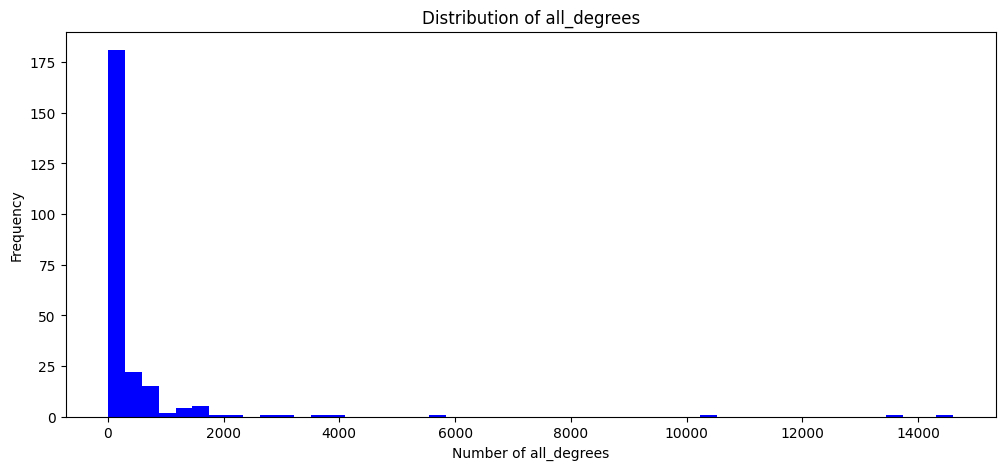

In [24]:
in_degrees = ponzi_ext.groupby('contract_address')[['from']].count().reset_index()
in_degrees = pd.merge(in_degrees, addresses, left_on='contract_address', right_on='address')
out_degrees = ponzi_int.groupby('contract_address')[['to']].count().reset_index()
out_degrees = pd.merge(out_degrees, addresses, left_on='contract_address', right_on='address')
all_degrees = pd.concat([in_degrees, out_degrees],axis=0)
all_degrees=all_degrees.fillna(0)
all_degrees['number of transactions']=all_degrees['from']+all_degrees['to']
all_degrees = all_degrees.groupby('contract_address')[['number of transactions']].sum().reset_index()
all_degrees = pd.merge(all_degrees, addresses, left_on='contract_address', right_on='address')
print('Total number of all_degrees for ponzi contracts:', sum(all_degrees['number of transactions']))
print('Average number of all_degrees for ponzi contracts:',np.round(np.mean(all_degrees['number of transactions']),2))
print('Standard deviation number of all_degrees for ponzi contracts:',np.round(np.std(all_degrees['number of transactions']),2))
print('Median number of all_degrees for ponzi contracts:', np.median(all_degrees['number of transactions']))
print('1st quartile number of all_degrees for ponzi contracts:', np.quantile(all_degrees['number of transactions'], q=0.25))
print('3rd quartile number of all_degrees for ponzi contracts:', np.quantile(all_degrees['number of transactions'], q=0.75))
max_val = np.max(all_degrees['number of transactions'])
print('Max number of all_degrees for ponzi contracts:', max_val, '--- Contract name:', all_degrees[all_degrees['number of transactions']==max_val].iloc[0,-1])
min_val = np.min(all_degrees['number of transactions'])
print('Min number of all_degrees for ponzi contracts:', np.min(all_degrees['number of transactions']), '--- Contract name:', all_degrees[all_degrees['number of transactions']==min_val].iloc[0,-1])
fig, ax = plt.subplots(figsize=(12,5))
ax.hist(all_degrees['number of transactions'], bins=50, color='blue')
ax.set_title('Distribution of all_degrees')
ax.set_xlabel('Number of all_degrees')
ax.set_ylabel('Frequency')
plt.show()

Total number of out-degrees for ponzi contracts: 29954
Average number of out-degrees for ponzi contracts: 128.56
Standard deviation number of out-degrees for ponzi contracts: 448.57
Median number of out-degrees for ponzi contracts: 23.0
1st quartile number of out-degrees for ponzi contracts: 5.0
3rd quartile number of out-degrees for ponzi contracts: 74.0
Max number of out-degrees for ponzi contracts: 4602 --- Contract name: PonziTokenV3
Min number of out-degrees for ponzi contracts: 1 --- Contract name: CryptoCopy: Token Sale


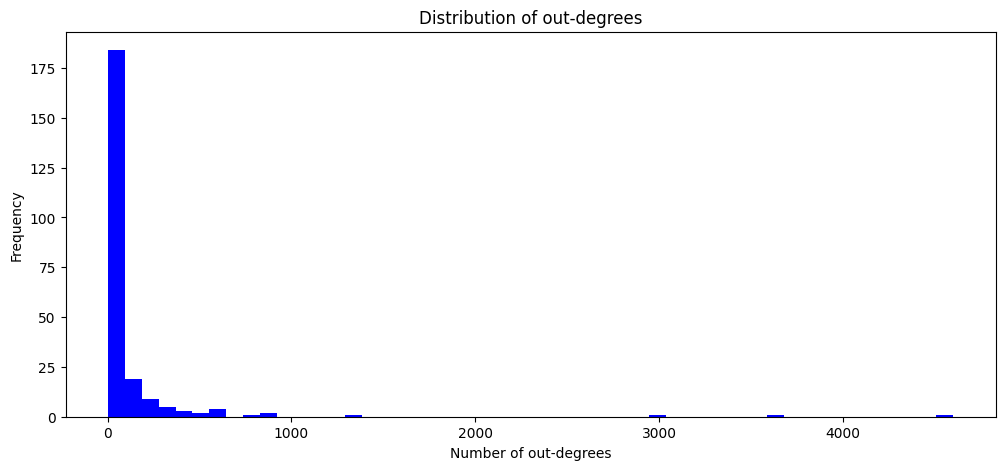

In [25]:
print('Total number of out-degrees for ponzi contracts:', sum(out_degrees['to']))
print('Average number of out-degrees for ponzi contracts:',np.round(np.mean(out_degrees['to']),2))
print('Standard deviation number of out-degrees for ponzi contracts:',np.round(np.std(out_degrees['to']),2))
print('Median number of out-degrees for ponzi contracts:', np.median(out_degrees['to']))
print('1st quartile number of out-degrees for ponzi contracts:', np.quantile(out_degrees['to'], q=0.25))
print('3rd quartile number of out-degrees for ponzi contracts:', np.quantile(out_degrees['to'], q=0.75))
max_val = np.max(out_degrees['to'])
print('Max number of out-degrees for ponzi contracts:', max_val, '--- Contract name:', out_degrees[out_degrees['to']==max_val].iloc[0,-1])
min_val = np.min(out_degrees['to'])
print('Min number of out-degrees for ponzi contracts:', np.min(out_degrees['to']), '--- Contract name:', out_degrees[out_degrees['to']==min_val].iloc[1,-1])
fig, ax = plt.subplots(figsize=(12,5))
ax.hist(out_degrees['to'], bins=50, color='blue')
ax.set_title('Distribution of out-degrees')
ax.set_xlabel('Number of out-degrees')
ax.set_ylabel('Frequency')
plt.show()

Total number of in-degrees for ponzi contracts: 79565
Average number of in-degrees for ponzi contracts: 332.91
Standard deviation number of in-degrees for ponzi contracts: 1213.9
Median number of in-degrees for ponzi contracts: 48.0
1st quartile number of in-degrees for ponzi contracts: 14.5
3rd quartile number of in-degrees for ponzi contracts: 209.0
Max number of in-degrees for ponzi contracts: 10033 --- Contract name: EthPyramid
Min number of in-degrees for ponzi contracts: 3 --- Contract name: EthMultiplier


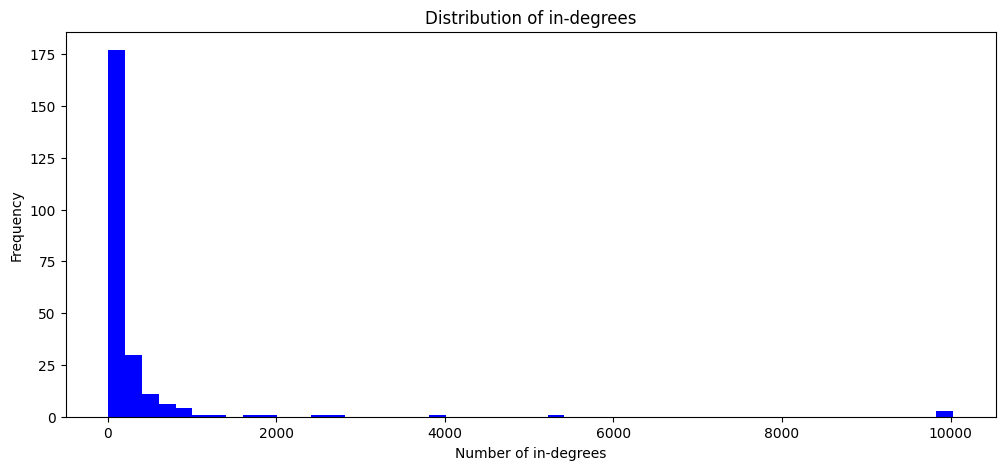

In [26]:
print('Total number of in-degrees for ponzi contracts:', sum(in_degrees['from']))
print('Average number of in-degrees for ponzi contracts:',np.round(np.mean(in_degrees['from']),2))
print('Standard deviation number of in-degrees for ponzi contracts:',np.round(np.std(in_degrees['from']),2))
print('Median number of in-degrees for ponzi contracts:', np.median(in_degrees['from']))
print('1st quartile number of in-degrees for ponzi contracts:', np.quantile(in_degrees['from'], q=0.25))
print('3rd quartile number of in-degrees for ponzi contracts:', np.quantile(in_degrees['from'], q=0.75))
max_val = np.max(in_degrees['from'])
print('Max number of in-degrees for ponzi contracts:', max_val, '--- Contract name:', in_degrees[in_degrees['from']==max_val].iloc[0,-1])
min_val = np.min(in_degrees['from'])
print('Min number of in-degrees for ponzi contracts:', np.min(in_degrees['from']), '--- Contract name:', in_degrees[in_degrees['from']==min_val].iloc[1,-1])
fig, ax = plt.subplots(figsize=(12,5))
ax.hist(in_degrees['from'], bins=50, color='blue')
ax.set_title('Distribution of in-degrees')
ax.set_xlabel('Number of in-degrees')
ax.set_ylabel('Frequency')
plt.show()

In [28]:
#all_cols_ponzi_ext = all_cols_ponzi_ext.rename({'from':'individual_node'}, axis=1)
all_cols_ponzi_ext['isinternal']=0
all_cols_ponzi_int['isinternal']=1
all_cols_ponzi_ext = all_cols_ponzi_ext[['from', 'to' ,'contract_address', 'cumulativeGasUsed', 'gasUsed', 'Date', 'Value_usd', 'Transaction_cost_usd', 'isError', 'isinternal']]
#all_cols_ponzi_int = all_cols_ponzi_int.rename({'to':'individual_node'}, axis=1)
all_cols_ponzi_int = all_cols_ponzi_int[['from', 'to' ,'contract_address', 'gasUsed', 'Date', 'Value_usd', 'isError', 'isinternal']]
all_ponzi_transactions = pd.concat([all_cols_ponzi_ext, all_cols_ponzi_int], axis=0)
#Filling missings for internal transactions
all_ponzi_transactions['Transaction_cost_usd']=all_ponzi_transactions['Transaction_cost_usd'].fillna(0)
all_ponzi_transactions['cumulativeGasUsed']=all_ponzi_transactions['cumulativeGasUsed'].fillna(0)
#Filtering out contracts with less than 3 nodes (the filtering is done with merged_payoffs)
all_ponzi_transactions= all_ponzi_transactions[all_ponzi_transactions['contract_address'].isin(all_degrees['contract_address'])].reset_index(drop=True)
#Adding contract name as a feature
all_ponzi_transactions = pd.merge(all_ponzi_transactions, addresses, left_on='contract_address', right_on='address').drop('address', axis=1).rename({'name':'contract_name'}, axis = 1)
#adding dummy
all_ponzi_transactions['is_ponzi']=1
#Constructing contract age
all_ponzi_transactions['Date'] = all_ponzi_transactions['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
all_ponzi_transactions=all_ponzi_transactions.sort_values(['contract_address', 'Date']).reset_index(drop=True)
date_born = all_ponzi_transactions.groupby('contract_address')[['Date']].min().reset_index().rename({'Date':'Date_born'}, axis=1)
all_ponzi_transactions = pd.merge(all_ponzi_transactions, date_born, on='contract_address', how='left')
all_ponzi_transactions['age_days'] = (all_ponzi_transactions['Date']-all_ponzi_transactions['Date_born']).dt.days
all_ponzi_transactions['age_minutes'] = (all_ponzi_transactions['Date']-all_ponzi_transactions['Date_born']).dt.seconds/60
all_ponzi_transactions.to_csv('all_ponzi_transactions_cleaned.csv', index=False)
all_ponzi_transactions.head()

,from,to,contract_address,cumulativeGasUsed,gasUsed,Date,Value_usd,Transaction_cost_usd,isError,isinternal,contract_name,is_ponzi,Date_born,age_days,age_minutes
0,0xd2e6b3bfe990fdede2380885d9d83ca9364e717e,0x00efd61b0d94ccd82f3922d26efdd3ed9859081a,0x00efd61b0d94ccd82f3922d26efdd3ed9859081a,7123739.0000,1515366,2018-04-10 17:55:17,0.0000,1.9460,0,0,EthPyramid,1,2018-04-10 17:55:17,0,0.0000
1,0x20c945800de43394f70d789874a4dac9cfa57451,0x00efd61b0d94ccd82f3922d26efdd3ed9859081a,0x00efd61b0d94ccd82f3922d26efdd3ed9859081a,3069896.0000,21000,2018-04-10 18:14:01,0.0000,0.0087,1,0,EthPyramid,1,2018-04-10 17:55:17,0,18.7333
2,0x0668dea6b5ec94d7ce3c43fe477888eee2fc1b2c,0x00efd61b0d94ccd82f3922d26efdd3ed9859081a,0x00efd61b0d94ccd82f3922d26efdd3ed9859081a,243354.0000,21110,2018-04-10 18:39:40,0.0000,0.0087,1,0,EthPyramid,1,2018-04-10 17:55:17,0,44.3833
3,0xd2e6b3bfe990fdede2380885d9d83ca9364e717e,0x00efd61b0d94ccd82f3922d26efdd3ed9859081a,0x00efd61b0d94ccd82f3922d26efdd3ed9859081a,179688.0000,127688,2018-04-10 21:17:03,124.2729,0.4284,0,0,EthPyramid,1,2018-04-10 17:55:17,0,201.7667
4,0xc951d3463ebba4e9ec8ddfe1f42bc5895c46ec8f,0x00efd61b0d94ccd82f3922d26efdd3ed9859081a,0x00efd61b0d94ccd82f3922d26efdd3ed9859081a,3752942.0000,27046,2018-04-10 21:18:04,1367.0019,0.0905,1,0,EthPyramid,1,2018-04-10 17:55:17,0,202.7833


# Non-Ponzi Contracts

In [29]:
non_ponzi_ext = pd.read_csv('all_np_external.csv')
non_ponzi_int = pd.read_csv('all_np_internal.csv')
non_ponzi_addresses = pd.read_csv('address_to_name_np.csv')

C:\Users\fabio\AppData\Local\Temp\ipykernel_31612\2049644116.py:1: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  non_ponzi_ext = pd.read_csv('all_np_external.csv')
C:\Users\fabio\AppData\Local\Temp\ipykernel_31612\2049644116.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  non_ponzi_int = pd.read_csv('all_np_internal.csv')


In [30]:
non_ponzi_addresses['address']=non_ponzi_addresses['address'].str.lower()
non_ponzi_addresses = non_ponzi_addresses.drop_duplicates(subset='address')

In [31]:
set_addresses = set(non_ponzi_addresses['address'])
def fixing_addresses(row):
    if row['from'] in set_addresses:
        return row['from']
    elif row['to'] in set_addresses:
        return row['to']
    elif pd.isna(row['to']) and pd.notna(row['contractAddress']):
        return row['contractAddress']
    else:
        return None

In [32]:
#Fixing NaN in non_ponzi_int => this enables to know when the contract is being created.
#Internal transactions with to = Nan are simply transactions used to create the contract
non_ponzi_int['contract_address']=non_ponzi_int.apply(fixing_addresses, axis=1)
to = []
for i in range(non_ponzi_int.shape[0]):
    if pd.isna(non_ponzi_int.loc[i, 'to']):
        to.append(non_ponzi_int.loc[i+1, 'from'])
    else:
        to.append(non_ponzi_int.loc[i, 'to'])
non_ponzi_int['to'] = to

#Dropping duplicate transactions
print('Number of transactions before cleaning:', non_ponzi_int.shape[0])
non_ponzi_int = non_ponzi_int.drop_duplicates(subset=['blockNumber', 'timeStamp', 'hash', 'from', 'to', 'value'])
non_ponzi_int=non_ponzi_int.reset_index()
print('Number of transactions after cleaning:', non_ponzi_int.shape[0])
non_ponzi_int['flag']= non_ponzi_int['from']==non_ponzi_int['contract_address']
non_ponzi_only_int = non_ponzi_int[non_ponzi_int['flag'] == True].reset_index(drop=True)
inflow_from_internal =  non_ponzi_int[non_ponzi_int['flag'] == False].reset_index(drop=True)
print('Number of contracts:', len(set(non_ponzi_int['contract_address'])))

Number of transactions before cleaning: 610250
Number of transactions after cleaning: 531734
Number of contracts: 1346


In [33]:
#Fixing NaN in non_ponzi_ext => this enables to know when the contract is being created.
#I am filling with bfill because transactions for each contract are ordered by date, therefore allowing to fill with the next value
non_ponzi_ext['to'] = non_ponzi_ext['to'].fillna(method='bfill')
#Dropping duplicate transactions
print('Number of transactions before cleaning:', non_ponzi_ext.shape[0])
non_ponzi_ext = non_ponzi_ext.drop_duplicates(subset=['blockNumber', 'timeStamp', 'hash','nonce', 'blockHash','transactionIndex', 'from', 'to', 'value'])
print('Number of transactions after cleaning:', non_ponzi_ext.shape[0])
print('Number of contracts:', len(set(non_ponzi_ext['to'])))

Number of transactions before cleaning: 4680106
Number of transactions after cleaning: 3202133
Number of contracts: 3338


In some cases, a contract may only have internal transactions if it does not receive direct external transactions from other Ethereum addresses. This may happen if the contract is not designed to receive Ether or if its interface is not publicly accessible.

Overall, a contract can have internal transactions even if it does not receive external transactions, as long as it interacts with other smart contracts or functions within its own code.

In [34]:
non_ponzi_ext['from'] = non_ponzi_ext.apply(determining_node, axis=1)
non_ponzi_ext['contract_address']=non_ponzi_ext['to']
non_ponzi_ext['individual_node']=non_ponzi_ext['from']
inflow_from_internal['individual_node']=inflow_from_internal['from']
non_ponzi_ext=pd.concat([non_ponzi_ext, inflow_from_internal], axis=0).reset_index(drop=True)
non_ponzi_only_int['individual_node']=non_ponzi_only_int['to']

C:\Users\fabio\AppData\Local\Temp\ipykernel_31612\1986450676.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_ponzi_ext['from'] = non_ponzi_ext.apply(determining_node, axis=1)
C:\Users\fabio\AppData\Local\Temp\ipykernel_31612\1986450676.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_ponzi_ext['contract_address']=non_ponzi_ext['to']
C:\Users\fabio\AppData\Local\Temp\ipykernel_31612\1986450676.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Number of contracts after filtering: 2151

Total number of all_degrees for non-ponzi contracts: 3653975
Average number of all_degrees for non-ponzi contracts: 1698.73
Standard deviation number of all_degrees for non-ponzi contracts: 3589.67
Median number of all_degrees for non-ponzi contracts: 86.0
1st quartile number of all_degrees for non-ponzi contracts: 16.0
3rd quartile number of all_degrees for non-ponzi contracts: 894.5
Max number of all_degrees for non-ponzi contracts: 20021 --- Contract name: ReplaySafeSplit
Min number of all_degrees for non-ponzi contracts: 3 --- Contract name: IconomiBlackHole


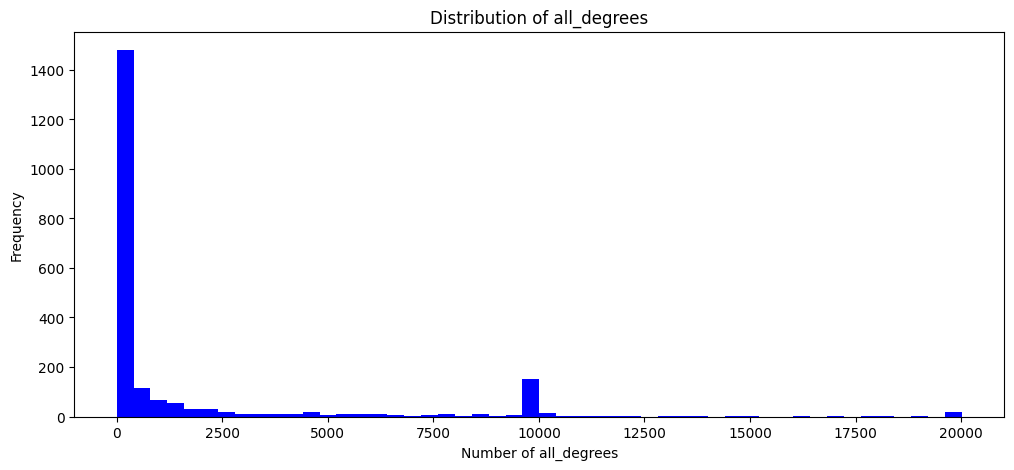

In [35]:
## Filtering contracts with less than 3 nodes
mask = pd.concat([non_ponzi_ext, non_ponzi_only_int], axis=0)
mask = mask[['individual_node', 'contract_address']]
mask = mask.groupby('contract_address')[['individual_node']].nunique().reset_index()
mask = mask[mask['individual_node']>=3]
print('Number of contracts after filtering:', mask.shape[0])
non_ponzi_ext = non_ponzi_ext[non_ponzi_ext['contract_address'].isin(mask['contract_address'])].reset_index(drop=True)
non_ponzi_only_int=non_ponzi_only_int[non_ponzi_only_int['contract_address'].isin(mask['contract_address'])].reset_index(drop=True)
## Creating in_degrees, out_degrees and all_degrees
in_degrees = non_ponzi_ext.groupby('contract_address')[['individual_node']].count().reset_index()
in_degrees = pd.merge(in_degrees, non_ponzi_addresses, left_on='contract_address', right_on='address')
out_degrees = non_ponzi_only_int.groupby('contract_address')[['individual_node']].count().reset_index()
out_degrees = pd.merge(out_degrees, non_ponzi_addresses, left_on='contract_address', right_on='address')
all_degrees = pd.concat([in_degrees, out_degrees],axis=0)
all_degrees = all_degrees.groupby('contract_address')[['individual_node']].sum().reset_index().rename({'individual_node':'number of transactions'}, axis=1)
all_degrees = pd.merge(all_degrees, non_ponzi_addresses, left_on='contract_address', right_on='address')
print('\nTotal number of all_degrees for non-ponzi contracts:', sum(all_degrees['number of transactions']))
print('Average number of all_degrees for non-ponzi contracts:',np.round(np.mean(all_degrees['number of transactions']),2))
print('Standard deviation number of all_degrees for non-ponzi contracts:',np.round(np.std(all_degrees['number of transactions']),2))
print('Median number of all_degrees for non-ponzi contracts:', np.median(all_degrees['number of transactions']))
print('1st quartile number of all_degrees for non-ponzi contracts:', np.quantile(all_degrees['number of transactions'], q=0.25))
print('3rd quartile number of all_degrees for non-ponzi contracts:', np.quantile(all_degrees['number of transactions'], q=0.75))
max_val = np.max(all_degrees['number of transactions'])
print('Max number of all_degrees for non-ponzi contracts:', max_val, '--- Contract name:', all_degrees[all_degrees['number of transactions']==max_val].iloc[0,-1])
min_val = np.min(all_degrees['number of transactions'])
print('Min number of all_degrees for non-ponzi contracts:', np.min(all_degrees['number of transactions']), '--- Contract name:', all_degrees[all_degrees['number of transactions']==min_val].iloc[0,-1])
fig, ax = plt.subplots(figsize=(12,5))
ax.hist(all_degrees['number of transactions'], bins=50, color='blue')
ax.set_title('Distribution of all_degrees')
ax.set_xlabel('Number of all_degrees')
ax.set_ylabel('Frequency')
plt.show()

Total number of out-degrees for non-ponzi contracts: 465524
Average number of out-degrees for non-ponzi contracts: 502.18
Standard deviation number of out-degrees for non-ponzi contracts: 1724.29
Median number of out-degrees for non-ponzi contracts: 8.0
1st quartile number of out-degrees for non-ponzi contracts: 2.0
3rd quartile number of out-degrees for non-ponzi contracts: 60.5
Max number of out-degrees for non-ponzi contracts: 10000 --- Contract name: CarTaxiBonus
Min number of out-degrees for non-ponzi contracts: 1 --- Contract name: BetOnHashV84


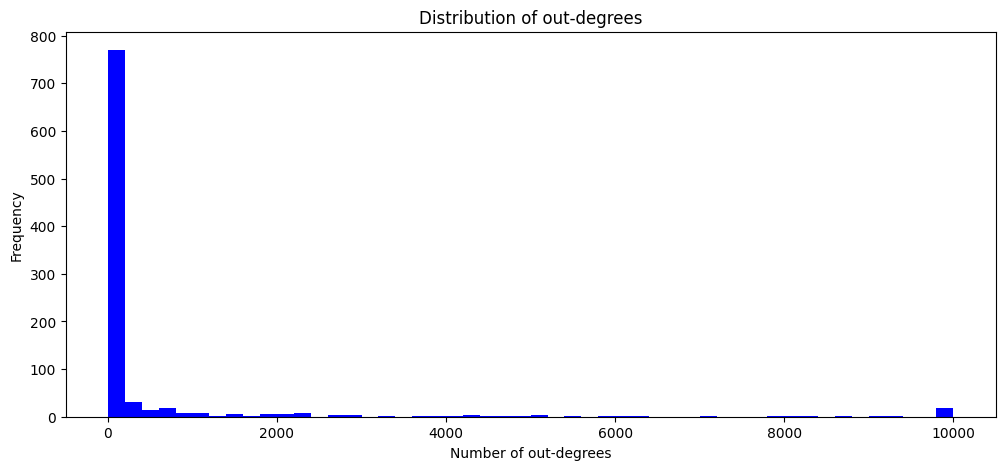

In [36]:
print('Total number of out-degrees for non-ponzi contracts:', sum(out_degrees['individual_node']))
print('Average number of out-degrees for non-ponzi contracts:',np.round(np.mean(out_degrees['individual_node']),2))
print('Standard deviation number of out-degrees for non-ponzi contracts:',np.round(np.std(out_degrees['individual_node']),2))
print('Median number of out-degrees for non-ponzi contracts:', np.median(out_degrees['individual_node']))
print('1st quartile number of out-degrees for non-ponzi contracts:', np.quantile(out_degrees['individual_node'], q=0.25))
print('3rd quartile number of out-degrees for non-ponzi contracts:', np.quantile(out_degrees['individual_node'], q=0.75))
max_val = np.max(out_degrees['individual_node'])
print('Max number of out-degrees for non-ponzi contracts:', max_val, '--- Contract name:', out_degrees[out_degrees['individual_node']==max_val].iloc[0,-1])
min_val = np.min(out_degrees['individual_node'])
print('Min number of out-degrees for non-ponzi contracts:', np.min(out_degrees['individual_node']), '--- Contract name:', out_degrees[out_degrees['individual_node']==min_val].iloc[1,-1])
fig, ax = plt.subplots(figsize=(12,5))
ax.hist(out_degrees['individual_node'], bins=50, color='blue')
ax.set_title('Distribution of out-degrees')
ax.set_xlabel('Number of out-degrees')
ax.set_ylabel('Frequency')
plt.show()

Total number of in-degrees for ponzi contracts: 3188451
Average number of in-degrees for ponzi contracts: 1508.97
Standard deviation number of in-degrees for ponzi contracts: 3083.7
Median number of in-degrees for ponzi contracts: 77.0
1st quartile number of in-degrees for ponzi contracts: 14.0
3rd quartile number of in-degrees for ponzi contracts: 790.0
Max number of in-degrees for ponzi contracts: 11388 --- Contract name: PixelMap
Min number of in-degrees for ponzi contracts: 1 --- Contract name: SportCrypt


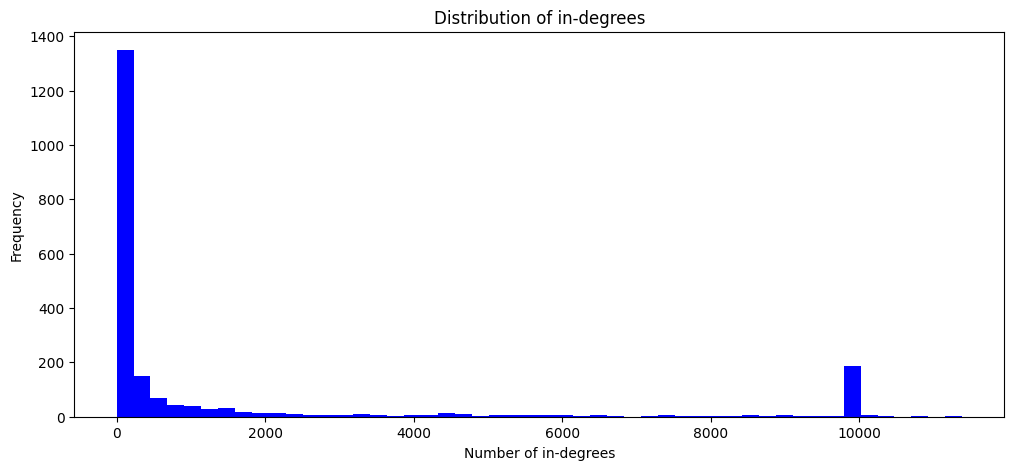

In [37]:
print('Total number of in-degrees for ponzi contracts:', sum(in_degrees['individual_node']))
print('Average number of in-degrees for ponzi contracts:',np.round(np.mean(in_degrees['individual_node']),2))
print('Standard deviation number of in-degrees for ponzi contracts:',np.round(np.std(in_degrees['individual_node']),2))
print('Median number of in-degrees for ponzi contracts:', np.median(in_degrees['individual_node']))
print('1st quartile number of in-degrees for ponzi contracts:', np.quantile(in_degrees['individual_node'], q=0.25))
print('3rd quartile number of in-degrees for ponzi contracts:', np.quantile(in_degrees['individual_node'], q=0.75))
max_val = np.max(in_degrees['individual_node'])
print('Max number of in-degrees for ponzi contracts:', max_val, '--- Contract name:', in_degrees[in_degrees['individual_node']==max_val].iloc[0,-1])
min_val = np.min(in_degrees['individual_node'])
print('Min number of in-degrees for ponzi contracts:', np.min(in_degrees['individual_node']), '--- Contract name:', in_degrees[in_degrees['individual_node']==min_val].iloc[1,-1])
fig, ax = plt.subplots(figsize=(12,5))
ax.hist(in_degrees['individual_node'], bins=50, color='blue')
ax.set_title('Distribution of in-degrees')
ax.set_xlabel('Number of in-degrees')
ax.set_ylabel('Frequency')
plt.show()

In [38]:
non_ponzi_ext['isinternal']=0
non_ponzi_only_int['isinternal']=1
non_ponzi_ext = non_ponzi_ext[['from','to', 'individual_node' ,'contract_address', 'cumulativeGasUsed', 'gasUsed', 'Date', 'Value_usd', 'Transaction_cost_usd', 'isError', 'isinternal']]
non_ponzi_only_int = non_ponzi_only_int[['from','to','individual_node','contract_address', 'gasUsed', 'Date', 'Value_usd', 'isError', 'isinternal']]
all_non_ponzi_transactions = pd.concat([non_ponzi_ext, non_ponzi_only_int], axis=0)
#Filling missings for internal transactions
all_non_ponzi_transactions['Transaction_cost_usd']=all_non_ponzi_transactions['Transaction_cost_usd'].fillna(0)
all_non_ponzi_transactions['cumulativeGasUsed']=all_non_ponzi_transactions['cumulativeGasUsed'].fillna(0)
#Filtering out contracts with less than 3 nodes
all_non_ponzi_transactions= all_non_ponzi_transactions[all_non_ponzi_transactions['contract_address'].isin(all_degrees['contract_address'])].reset_index(drop=True)
#Adding contract name as a feature
all_non_ponzi_transactions = pd.merge(all_non_ponzi_transactions, non_ponzi_addresses, left_on='contract_address', right_on='address').drop('address', axis=1).rename({'name':'contract_name'}, axis = 1)
#adding dummy
all_non_ponzi_transactions['is_ponzi']=0
#Constructing contract age
all_non_ponzi_transactions['Date'] = all_non_ponzi_transactions['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
all_non_ponzi_transactions=all_non_ponzi_transactions.sort_values(['contract_address', 'Date']).reset_index(drop=True)
age_days = []
date_born = all_non_ponzi_transactions.groupby('contract_address')[['Date']].min().reset_index().rename({'Date':'Date_born'}, axis=1)     
all_non_ponzi_transactions = pd.merge(all_non_ponzi_transactions, date_born, on='contract_address', how='left')
all_non_ponzi_transactions['age_days'] = (all_non_ponzi_transactions['Date']-all_non_ponzi_transactions['Date_born']).dt.days  
all_non_ponzi_transactions['age_minutes'] = (all_non_ponzi_transactions['Date']-all_non_ponzi_transactions['Date_born']).dt.seconds/60 
all_non_ponzi_transactions.head()
all_non_ponzi_transactions.to_csv('all_non_ponzi_transactions_cleaned.csv', index=False)

In [39]:
all_non_ponzi_transactions.head() 

,from,to,individual_node,contract_address,cumulativeGasUsed,gasUsed,Date,Value_usd,Transaction_cost_usd,isError,isinternal,contract_name,is_ponzi,Date_born,age_days,age_minutes
0,0x831729900f2b323111a76dea99f695a42c7dbc66,0x0006157838d5a6b33ab66588a6a693a57c869999,0x831729900f2b323111a76dea99f695a42c7dbc66,0x0006157838d5a6b33ab66588a6a693a57c869999,0.0000,0,2017-08-07 19:50:09,0.2502,0.0000,1,0,IconomiBlackHole,0,2017-08-07 19:50:09,0,0.0000
1,0x0b57dffe052b17e84f0289dabe2551bab9849264,0x0006157838d5a6b33ab66588a6a693a57c869999,0x0b57dffe052b17e84f0289dabe2551bab9849264,0x0006157838d5a6b33ab66588a6a693a57c869999,0.0000,0,2017-11-04 06:18:27,0.2074,0.0000,0,0,IconomiBlackHole,0,2017-08-07 19:50:09,88,628.3000
2,0x0cbd60b5800fdca627fca0cea0406b7805e0161a,0x0006157838d5a6b33ab66588a6a693a57c869999,0x0cbd60b5800fdca627fca0cea0406b7805e0161a,0x0006157838d5a6b33ab66588a6a693a57c869999,0.0000,0,2018-02-03 10:06:37,0.7674,0.0000,1,0,IconomiBlackHole,0,2017-08-07 19:50:09,179,856.4667
3,0xa35fe1bcfde297a328dd4ef0bc902fb1ca7661cb,0x001a589dda0d6be37632925eaf1256986b2c6ad0,0xa35fe1bcfde297a328dd4ef0bc902fb1ca7661cb,0x001a589dda0d6be37632925eaf1256986b2c6ad0,1914825.0000,1893825,2016-07-19 17:26:36,0.0000,0.4405,0,0,Oraclize,0,2016-07-19 17:26:36,0,0.0000
4,0xa35fe1bcfde297a328dd4ef0bc902fb1ca7661cb,0x001a589dda0d6be37632925eaf1256986b2c6ad0,0xa35fe1bcfde297a328dd4ef0bc902fb1ca7661cb,0x001a589dda0d6be37632925eaf1256986b2c6ad0,341838.0000,84011,2016-07-19 17:27:17,0.0000,0.0195,0,0,Oraclize,0,2016-07-19 17:26:36,0,0.6833


--- Transaction costs by contract ---
Total Transaction costs by contract: $ 3864374.5
Avg Transaction costs by contract: $ 1869.56
Standard deviation Transaction costs by contract: $ 11811.76
Median Transaction costs by contract: $ 57.97
1st Quartile Transaction costs by contract: $ 9.72
3rd Quartile Transaction costs by contract: $ 551.94
Max Transaction costs by contract: $ 452894.06
Min Transaction costs by contract: $ 0.0

--- Transaction costs by user ---
Total Transaction costs by user: $ 3864374.5
Avg Transaction costs by user: $ 6.01
Standard deviation Transaction costs by user: $ 176.67
Median Transaction costs by user: $ 0.8
1st Quartile Transaction costs by user: $ 0.2
3rd Quartile Transaction costs by user: $ 2.75
Max Transaction costs by user: $ 57543.14
Min Transaction costs by user: $ 0.0


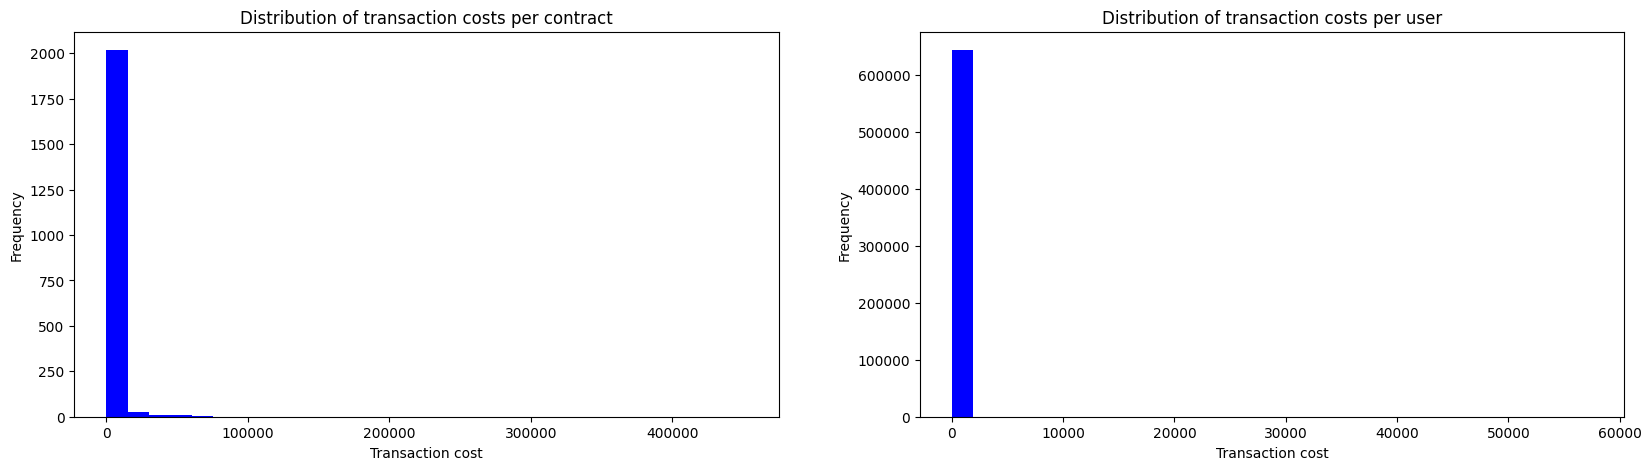

In [40]:
#Transaction costs are present only for external transactions
temp_df = all_non_ponzi_transactions[all_non_ponzi_transactions['Transaction_cost_usd']>0].reset_index(drop=True)
print('--- Transaction costs by contract ---')
temp_df_contract = temp_df.groupby('contract_address')[['Transaction_cost_usd']].sum().reset_index()
print('Total Transaction costs by contract: $', np.round(np.sum(temp_df_contract['Transaction_cost_usd']),2))
print('Avg Transaction costs by contract: $', np.round(np.mean(temp_df_contract['Transaction_cost_usd']),2))
print('Standard deviation Transaction costs by contract: $', np.round(np.std(temp_df_contract['Transaction_cost_usd']),2))
print('Median Transaction costs by contract: $', np.round(np.median(temp_df_contract['Transaction_cost_usd']),2))
print('1st Quartile Transaction costs by contract: $', np.round(np.quantile(temp_df_contract['Transaction_cost_usd'], 0.25),2))
print('3rd Quartile Transaction costs by contract: $', np.round(np.quantile(temp_df_contract['Transaction_cost_usd'], 0.75),2))
print('Max Transaction costs by contract: $', np.round(np.max(temp_df_contract['Transaction_cost_usd']), 2))
print('Min Transaction costs by contract: $', np.round(np.min(temp_df_contract['Transaction_cost_usd']), 2))

fig, axs = plt.subplots(ncols=2,figsize=(20,5))
ax=axs[0]
ax.hist(temp_df_contract['Transaction_cost_usd'], bins=30, color='blue')
ax.set_title('Distribution of transaction costs per contract')
ax.set_xlabel('Transaction cost')
ax.set_ylabel('Frequency')

print('\n--- Transaction costs by user ---')
temp_df_individual = temp_df.groupby('individual_node')[['Transaction_cost_usd']].sum().reset_index()
print('Total Transaction costs by user: $', np.round(np.sum(temp_df_individual['Transaction_cost_usd']),2))
print('Avg Transaction costs by user: $', np.round(np.mean(temp_df_individual['Transaction_cost_usd']),2))
print('Standard deviation Transaction costs by user: $', np.round(np.std(temp_df_individual['Transaction_cost_usd']),2))
print('Median Transaction costs by user: $', np.round(np.median(temp_df_individual['Transaction_cost_usd']),2))
print('1st Quartile Transaction costs by user: $', np.round(np.quantile(temp_df_individual['Transaction_cost_usd'], 0.25),2))
print('3rd Quartile Transaction costs by user: $', np.round(np.quantile(temp_df_individual['Transaction_cost_usd'], 0.75),2))
print('Max Transaction costs by user: $', np.round(np.max(temp_df_individual['Transaction_cost_usd']), 2))
print('Min Transaction costs by user: $', np.round(np.min(temp_df_individual['Transaction_cost_usd']), 2))
ax=axs[1]
ax.hist(temp_df_individual['Transaction_cost_usd'], bins=30, color='blue')
ax.set_title('Distribution of transaction costs per user')
ax.set_xlabel('Transaction cost')
ax.set_ylabel('Frequency')

plt.show()

In [41]:
print('----- Errors internal transactions -----')
temp_df = all_non_ponzi_transactions[all_non_ponzi_transactions['Transaction_cost_usd']==0].reset_index(drop=True)
temp_df = temp_df.groupby('contract_address')[['isError']].sum()
print('Total Errors:', np.round(np.sum(temp_df['isError']),2))
print('Avg Errors:', np.round(np.mean(temp_df['isError']),2))
print('Standard deviation Errors:', np.round(np.std(temp_df['isError']),2))
print('Median Errors:', np.round(np.median(temp_df['isError']),2))
print('1st Quartile Errors:', np.round(np.quantile(temp_df['isError'], 0.25),2))
print('3rd Quartile Errors:', np.round(np.quantile(temp_df['isError'], 0.75),2))
print('Max Errors:', np.round(np.max(temp_df['isError']), 2))
print('Min Errors:', np.round(np.min(temp_df['isError']), 2))
print('\n----- Errors external transactions -----')
temp_df = all_non_ponzi_transactions[all_non_ponzi_transactions['Transaction_cost_usd']>0].reset_index(drop=True)
temp_df = temp_df.groupby('contract_address')[['isError']].sum()
print('Total Errors:', np.round(np.sum(temp_df['isError']),2))
print('Avg Errors:', np.round(np.mean(temp_df['isError']),2))
print('Standard deviation Errors:', np.round(np.std(temp_df['isError']),2))
print('Median Errors:', np.round(np.median(temp_df['isError']),2))
print('1st Quartile Errors:', np.round(np.quantile(temp_df['isError'], 0.25),2))
print('3rd Quartile Errors:', np.round(np.quantile(temp_df['isError'], 0.75),2))
print('Max Errors:', np.round(np.max(temp_df['isError']), 2))
print('Min Errors:', np.round(np.min(temp_df['isError']), 2))

----- Errors internal transactions -----
Total Errors: 9841
Avg Errors: 9.81
Standard deviation Errors: 117.41
Median Errors: 0.0
1st Quartile Errors: 0.0
3rd Quartile Errors: 0.0
Max Errors: 3279
Min Errors: 0

----- Errors external transactions -----
Total Errors: 272025
Avg Errors: 131.6
Standard deviation Errors: 519.74
Median Errors: 5.0
1st Quartile Errors: 1.0
3rd Quartile Errors: 44.5
Max Errors: 9907
Min Errors: 0


Max lifetime: 2742 days --- Contract name: CryptoPay: CPAY Token
Min lifetime: 0 days --- Contract name: IconomiBlackHole
Avg lifetime: 428.17 days
Standard deviation lifetime: 618.6 days
Median lifetime: 105.0 days
1st quartile lifetime: 16.5 days
3rd quartile lifetime: 587.0 days


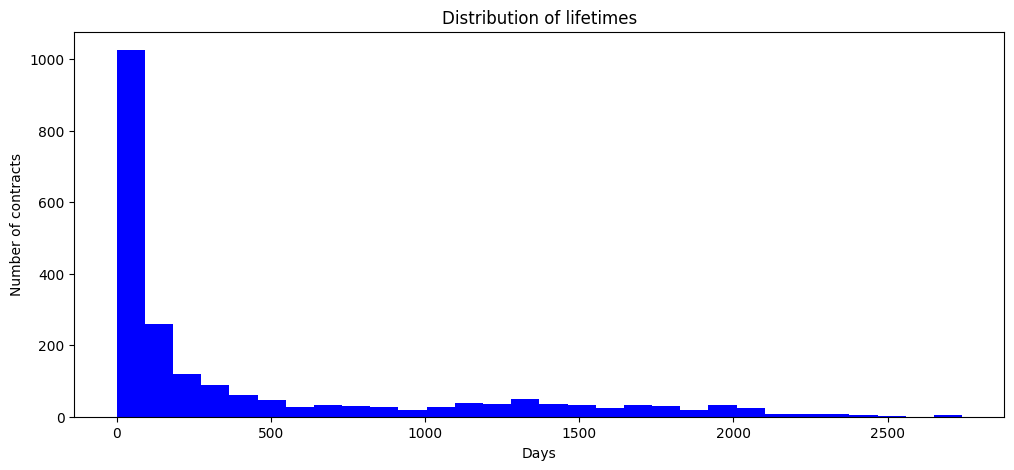

In [42]:
### Contracts lifetime
lifetimes = all_non_ponzi_transactions.groupby('contract_address')[['age_days']].max().reset_index()
print('Max lifetime:', max(lifetimes['age_days']), 'days --- Contract name:', all_non_ponzi_transactions[all_non_ponzi_transactions['age_days']==max(lifetimes['age_days'])]['contract_name'].iloc[0])
print('Min lifetime:', min(lifetimes['age_days']), 'days --- Contract name:', all_non_ponzi_transactions[all_non_ponzi_transactions['age_days']==min(lifetimes['age_days'])]['contract_name'].iloc[0])

print('Avg lifetime:', np.round(np.mean(lifetimes['age_days']),2), 'days')
print('Standard deviation lifetime:',np.round(np.std(lifetimes['age_days']),2), 'days')
print('Median lifetime:', np.median(lifetimes['age_days']), 'days')
print('1st quartile lifetime:', np.quantile(lifetimes['age_days'], q=0.25), 'days')
print('3rd quartile lifetime:', np.quantile(lifetimes['age_days'], q=0.75), 'days')

fig, ax = plt.subplots(figsize=(12,5))
ax.hist(lifetimes['age_days'], color='blue', bins=30)
ax.set_title('Distribution of lifetimes')
ax.set_xlabel('Days')
ax.set_ylabel('Number of contracts')
plt.show()

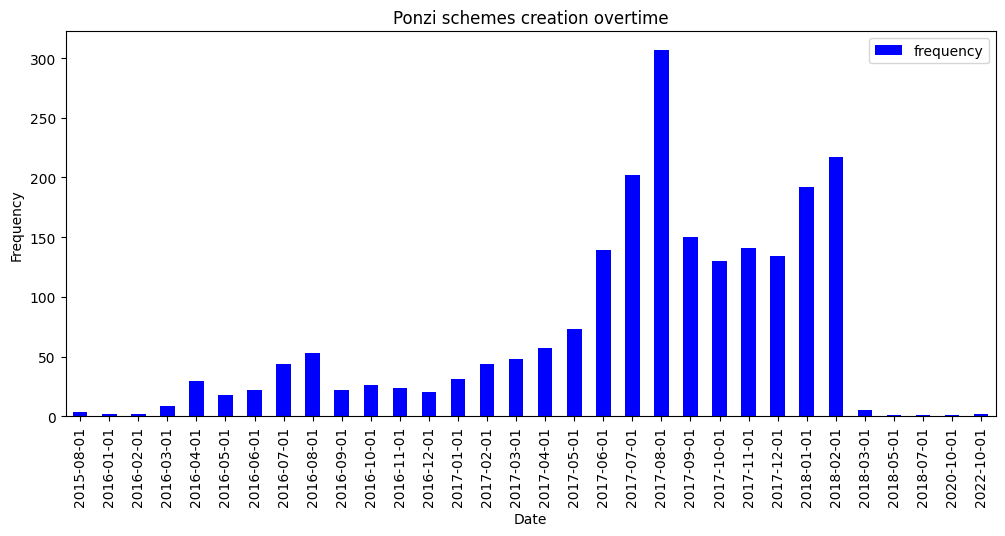

In [43]:
all_non_ponzi_transactions['Date_notgranular']=all_non_ponzi_transactions['Date'].astype(str).apply(lambda x: datetime.strptime(x[:7], '%Y-%m'))
all_non_ponzi_transactions_dateborn = all_non_ponzi_transactions.groupby('contract_address')[['Date_notgranular']].min().reset_index()
fig, ax = plt.subplots(figsize=(12,5))
all_non_ponzi_transactions_dateborn=all_non_ponzi_transactions_dateborn.groupby('Date_notgranular').count().reset_index().rename({'contract_address':'frequency'},axis=1)
all_non_ponzi_transactions_dateborn['Date_notgranular']=all_non_ponzi_transactions_dateborn['Date_notgranular'].astype(str)
all_non_ponzi_transactions_dateborn.plot.bar('Date_notgranular', 'frequency', ax=ax, color='blue')
ax.set_xlabel('Date')
ax.set_ylabel('Frequency')
ax.set_title('Ponzi schemes creation overtime')
all_non_ponzi_transactions.drop('Date_notgranular', axis=1,inplace=True)
plt.show()

In [44]:
print('----- Inflow transactions ----- \n')

print('Total amount of money collected: $', f'{np.round(non_ponzi_ext.Value_usd.sum(),2):,}')

temp_df = non_ponzi_ext.groupby('contract_address')[['Value_usd']].sum().reset_index()
temp_df = temp_df[temp_df['Value_usd']==temp_df['Value_usd'].max()].reset_index(drop=True)
print('Max money attracted by a contract: $', f'{np.round(temp_df.iloc[0,1],2):,}',' --- Contract associated:', all_non_ponzi_transactions[all_non_ponzi_transactions['contract_address']==temp_df.iloc[0,0]]['contract_name'].iloc[0])

temp_df = non_ponzi_ext.groupby('contract_address')[['Value_usd']].sum().reset_index()
temp_df = temp_df[temp_df['Value_usd']==temp_df['Value_usd'].min()].reset_index(drop=True)
print('Min money attracted by a contract: $', f'{np.round(temp_df.iloc[0,1],2):,}',' --- Contract associated:', all_non_ponzi_transactions[all_non_ponzi_transactions['contract_address']==temp_df.iloc[0,0]]['contract_name'].iloc[0])

temp_df = non_ponzi_ext.groupby('contract_address')[['Value_usd']].sum().reset_index()
print('Avg money attracted by a contract: $', f'{np.round(np.mean(temp_df.Value_usd),2):,}')
print('Standard deviation money attracted by a contract: $', f'{np.round(np.std(temp_df.Value_usd),2):,}')
print('Median money attracted by a contract: $', f'{np.round(np.median(temp_df.Value_usd),2):,}')
print('1st Quartile money attracted by a contract: $', f'{np.round(np.quantile(temp_df.Value_usd, 0.25),2):,}')
print('3rd Quartile money attracted by a contract: $', f'{np.round(np.quantile(temp_df.Value_usd, 0.75),2):,}')

print('\n----- Outflow transactions ----- \n')

print('Total amount of money collected: $', f'{np.round(non_ponzi_int.Value_usd.sum(),2):,}')

temp_df = non_ponzi_int.groupby('contract_address')[['Value_usd']].sum().reset_index()
temp_df = temp_df[temp_df['Value_usd']==temp_df['Value_usd'].max()].reset_index(drop=True)
print('Max money paid by a contract: $', f'{np.round(temp_df.iloc[0,1],2):,}',' --- Contract associated:', all_non_ponzi_transactions[all_non_ponzi_transactions['contract_address']==temp_df.iloc[0,0]]['contract_name'].iloc[0])

temp_df = non_ponzi_int.groupby('contract_address')[['Value_usd']].sum().reset_index()
temp_df = temp_df[temp_df['Value_usd']==temp_df['Value_usd'].min()].reset_index(drop=True)
print('Min money paid by a contract: $', f'{np.round(temp_df.iloc[0,1],2):,}',' --- Contract associated:', all_non_ponzi_transactions[all_non_ponzi_transactions['contract_address']==temp_df.iloc[0,0]]['contract_name'].iloc[0])

temp_df = non_ponzi_int.groupby('contract_address')[['Value_usd']].sum().reset_index()
print('Avg money paid by a contract: $', f'{np.round(np.mean(temp_df.Value_usd),2):,}')
print('Standard deviation money paid by a contract: $', f'{np.round(np.std(temp_df.Value_usd),2):,}')
print('Median money paid by a contract: $', f'{np.round(np.median(temp_df.Value_usd),2):,}')
print('1st Quartile money paid by a contract: $', f'{np.round(np.quantile(temp_df.Value_usd, 0.25),2):,}')
print('3rd Quartile money paid by a contract: $', f'{np.round(np.quantile(temp_df.Value_usd, 0.75),2):,}')

----- Inflow transactions ----- 

Total amount of money collected: $ 2,930,827,144.09
Max money attracted by a contract: $ 182,597,243.68  --- Contract associated: Basic Attention: BAT Token
Min money attracted by a contract: $ 0.0  --- Contract associated: Token
Avg money attracted by a contract: $ 1,387,045.5
Standard deviation money attracted by a contract: $ 8,755,848.1
Median money attracted by a contract: $ 332.78
1st Quartile money attracted by a contract: $ 1.43
3rd Quartile money attracted by a contract: $ 37,417.53

----- Outflow transactions ----- 

Total amount of money collected: $ 3,395,118,550.6
Max money paid by a contract: $ 1,078,281,192.51  --- Contract associated: Bitfinex: MultiSig 1
Min money paid by a contract: $ 0.0  --- Contract associated: BetOnHashV84
Avg money paid by a contract: $ 2,522,376.34
Standard deviation money paid by a contract: $ 30,795,932.6
Median money paid by a contract: $ 455.89
1st Quartile money paid by a contract: $ 4.38
3rd Quartile money

In [45]:
temp_df = non_ponzi_ext.groupby('contract_address')[['individual_node']].nunique().reset_index()
print('--- Contracts in-degrees ---')
print('Total number of individual users:', np.round(np.sum(temp_df['individual_node']),2))
print('Average number of individual users:', np.round(np.mean(temp_df['individual_node']),2))
print('Standard deviation:', np.round(np.std(temp_df['individual_node']),2))
print('Median number of individual users:', np.round(np.median(temp_df['individual_node']),2))
print('1st Quartile:', np.round(np.quantile(temp_df['individual_node'], 0.25),2))
print('3rd Quartile:', np.round(np.quantile(temp_df['individual_node'], 0.75),2))
print('Max individuals:', np.round(np.max(temp_df['individual_node']), 2))
print('Min individuals:', np.round(np.min(temp_df['individual_node']), 2))

temp_df = non_ponzi_only_int.groupby('contract_address')[['individual_node']].nunique().reset_index()
print('\n--- Contracts out-degrees ---')
print('Total number of individual users:', np.round(np.sum(temp_df['individual_node']),2))
print('Average number of individual users:', np.round(np.mean(temp_df['individual_node']),2))
print('Standard deviation:', np.round(np.std(temp_df['individual_node']),2))
print('Median number of individual users:', np.round(np.median(temp_df['individual_node']),2))
print('1st Quartile:', np.round(np.quantile(temp_df['individual_node'], 0.25),2))
print('3rd Quartile:', np.round(np.quantile(temp_df['individual_node'], 0.75),2))
print('Max individuals:', np.round(np.max(temp_df['individual_node']), 2))
print('Min individuals:', np.round(np.min(temp_df['individual_node']), 2))

--- Contracts in-degrees ---
Total number of individual users: 988215
Average number of individual users: 467.68
Standard deviation: 1217.66
Median number of individual users: 18.0
1st Quartile: 4.0
3rd Quartile: 199.0
Max individuals: 8706
Min individuals: 1

--- Contracts out-degrees ---
Total number of individual users: 44055
Average number of individual users: 47.52
Standard deviation: 307.46
Median number of individual users: 2.0
1st Quartile: 1.0
3rd Quartile: 4.0
Max individuals: 4530
Min individuals: 1


In [46]:
temp_df = non_ponzi_ext.groupby('individual_node')[['Value_usd']].sum().reset_index()

print('--- Amounts paid by users ---')
print('Total: $', f'{np.round(np.sum(temp_df.Value_usd), 2):,}')
print('Average: $', f'{np.round(np.mean(temp_df.Value_usd), 2):,}')
print('Standard deviation: $',f'{np.round(np.std(temp_df.Value_usd), 2):,}')
print('Median: $', f'{np.round(np.median(temp_df.Value_usd), 2):,}')
print('1st Quartile: $', f'{np.round(np.quantile(temp_df.Value_usd, 0.25), 2):,}')
print('3rd Quartile: $', f'{np.round(np.quantile(temp_df.Value_usd, 0.75), 2):,}')
print('Max: $', f'{np.round(np.max(temp_df.Value_usd), 2):,}')
print('Min: $', f'{np.round(np.min(temp_df.Value_usd), 2):,}')

temp_df = non_ponzi_only_int.groupby('individual_node')[['Value_usd']].sum().reset_index()
print('\n--- Amounts received by users ---')
print('Total: $', f'{np.round(np.sum(temp_df.Value_usd), 2):,}')
print('Average: $', f'{np.round(np.mean(temp_df.Value_usd), 2):,}')
print('Standard deviation: $',f'{np.round(np.std(temp_df.Value_usd), 2):,}')
print('Median: $', f'{np.round(np.median(temp_df.Value_usd), 2):,}')
print('1st Quartile: $', f'{np.round(np.quantile(temp_df.Value_usd, 0.25), 2):,}')
print('3rd Quartile: $', f'{np.round(np.quantile(temp_df.Value_usd, 0.75), 2):,}')
print('Max: $', f'{np.round(np.max(temp_df.Value_usd), 2):,}')
print('Min: $', f'{np.round(np.min(temp_df.Value_usd), 2):,}')

--- Amounts paid by users ---
Total: $ 2,930,827,144.09
Average: $ 4,518.4
Standard deviation: $ 223,541.0
Median: $ 0.0
1st Quartile: $ 0.0
3rd Quartile: $ 651.47
Max: $ 132,467,397.08
Min: $ 0.0

--- Amounts received by users ---
Total: $ 3,053,158,260.62
Average: $ 74,674.91
Standard deviation: $ 3,406,969.16
Median: $ 10.79
1st Quartile: $ 0.39
3rd Quartile: $ 715.86
Max: $ 560,395,095.13
Min: $ 0.0
